# Helen (MJF-1B): Parkinson's Freezing of Gait 
Link to kaggle competition dataset and info: 
- https://www.kaggle.com/competitions/tlvmc-parkinsons-freezing-gait-prediction/data
## Objective:
- To detect the start and stop of each freezing episode and the occurrence in these series of three types of freezing of gait events:
  - Start Hesitation
  - Turn
  - Walking

## File and Field Description
- train/ Folder containing the data series in the training set within three subfolders: tdcsfog/, defog/, and notype/.
- Series in the notype folder are from the defog dataset but lack event-type annotations.
- The fields present in these series vary by folder.
  - Time An integer timestep. Series from the tdcsfog dataset are recorded at 128Hz (128 timesteps per second), while series from the defog and daily series are recorded at 100Hz (100 timesteps per second).
  - AccV, AccML, and AccAP Acceleration from a lower-back sensor on three axes: V - vertical, ML - mediolateral, AP - anteroposterior. Data is in units of m/s^2 for tdcsfog/ and g for defog/ and notype/.
  - StartHesitation, Turn, Walking Indicator variables for the occurrence of each of the event types.
  - Event Indicator variable for the occurrence of any FOG-type event. Present only in the notype series, which lack type-level annotations.
  - Valid There were cases during the video annotation that were hard for the annotator to decide if there was an Akinetic (i.e., essentially no movement) FoG or the subject stopped voluntarily. Only event annotations where the series is marked true should be considered as unambiguous.
  - Task Series were only annotated where this value is true. Portions marked false should be considered unannotated.
    
- Note that the Valid and Task fields are only present in the defog dataset. They are not relevant for the tdcsfog data.

# Data Exploration 
Objectives:
- Set up IDE and download relevant Python libraries.
- Load and inspect the three training sets from Parkinson’s FoG Kaggle Folder.
- Standardize categorical variables, and normalize numerical features.
- Understand the structure, types of sensors, and data format.

In [2]:
# Disable history so database is not readonly
%config HistoryManager.enabled = False

## Import Python Libraries

In [54]:
# Import necessary Python libraries
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from scipy.signal import butter, filtfilt
from scipy import signal

## Inspect Dataset Contents

In [4]:
# List all relevant files, folders, and subfolders 
all_files = os.listdir('../input/tlvmc-parkinsons-freezing-gait-prediction')
print('All competition datasets:')
print(all_files)

train_files = os.listdir('../input/tlvmc-parkinsons-freezing-gait-prediction/train')
print('\nFolders in train:')
print(train_files)

defog_path = '../input/tlvmc-parkinsons-freezing-gait-prediction/train/defog'
defog_files = os.listdir(defog_path)
print('\nFiles in defog:')
print(f'{defog_files[:10]}... plus {len(defog_files)-10} more remaining csv files')

tdcsfog_path = '../input/tlvmc-parkinsons-freezing-gait-prediction/train/tdcsfog'
tdcsfog_files = os.listdir(tdcsfog_path)
print('\nFiles in tdcsfog:')
print(f'{tdcsfog_files[:10]}... plus {len(tdcsfog_files)-10} more remaining csv files')

All competition datasets:
['sample_submission.csv', 'unlabeled', 'subjects.csv', 'tasks.csv', 'defog_metadata.csv', 'daily_metadata.csv', 'test', 'events.csv', 'tdcsfog_metadata.csv', 'train']

Folders in train:
['defog', 'tdcsfog', 'notype']

Files in defog:
['be9d33541d.csv', '4c3aa8ea6e.csv', '18e7abc37e.csv', '6a20935af5.csv', 'e642d9ea5f.csv', '3f3b08f78d.csv', '68e7e02a47.csv', 'f17eacf7d8.csv', '3f970065e5.csv', '7030643376.csv']... plus 81 more remaining csv files

Files in tdcsfog:
['a171e61840.csv', '4171ea3a0c.csv', '0f985a8440.csv', '5d320ade20.csv', 'ae8c67086b.csv', 'b7214cbf21.csv', 'e18fcafee8.csv', '79568b8e25.csv', 'feba449e1a.csv', '7ebad45aec.csv']... plus 823 more remaining csv files


## Combine CSV Files into a Single Dataset
- Dataframes for: defog, tdcsfog, notype
- Add patientID column as unique identifier of each csv file

In [5]:
# Function to combine all csv files in folder with a unique identifier column 
def CombineDataset(path, df):
    # glob.glob('folder/*.type') -> look inside folder and return all files of .type
    for file in glob.glob(f'{path}/*.csv'):
        
        # Get the unqiue identifier of file (name of csv file)
        # os.path.basename(...) -> strips the directory, leaving only the filename.csv
        # os.path.splittext('filename.csv') -> splits into tuple ('filename'. '.csv')
        patientID = os.path.splitext(os.path.basename(file))[0]

        temp_df = pd.read_csv(file)
        
        # Create a new column for the ID
        temp_df['PatientID'] = patientID

        # Combine into one, final dataframe 
        df = pd.concat([df, temp_df], ignore_index=True)

    return df 

In [6]:
# Initialize an empty defog dataframe 
defog_df = pd.DataFrame()

# Call the above function to combine all csv files in defog 
defog_df = CombineDataset(defog_path, defog_df)
defog_df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,PatientID
0,0,-1.002697,0.022371,0.068304,0,0,0,False,False,be9d33541d
1,1,-1.002641,0.019173,0.066162,0,0,0,False,False,be9d33541d
2,2,-0.999820,0.019142,0.067536,0,0,0,False,False,be9d33541d
3,3,-0.998023,0.018378,0.068409,0,0,0,False,False,be9d33541d
4,4,-0.998359,0.016726,0.066448,0,0,0,False,False,be9d33541d


In [7]:
# Initialize an empty tdcsfog dataframe 
tdcsfog_df = pd.DataFrame()

# Call the above function to combine all csv files in tdcsfog 
tdcsfog_df = CombineDataset(tdcsfog_path, tdcsfog_df)
tdcsfog_df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,PatientID
0,0,-9.665890,0.042550,0.184744,0,0,0,a171e61840
1,1,-9.672969,0.049217,0.184644,0,0,0,a171e61840
2,2,-9.670260,0.033620,0.193790,0,0,0,a171e61840
3,3,-9.673356,0.035159,0.184369,0,0,0,a171e61840
4,4,-9.671458,0.043913,0.197814,0,0,0,a171e61840


In [8]:
# Check that PatientID column logic was implemented correctly 
unique_ids = defog_df['PatientID'].unique()
print(unique_ids[:10])

['be9d33541d' '4c3aa8ea6e' '18e7abc37e' '6a20935af5' 'e642d9ea5f'
 '3f3b08f78d' '68e7e02a47' 'f17eacf7d8' '3f970065e5' '7030643376']


In [9]:
# Shape of each dataframe (rows, col) 
print(f"\nCombined defog shape: ({defog_df.shape[0]} rows, {defog_df.shape[1]} cols)")
print(f"\nCombined tdcsfog shape: ({tdcsfog_df.shape[0]} rows, {tdcsfog_df.shape[1]} cols)")


Combined defog shape: (13525702 rows, 10 cols)

Combined tdcsfog shape: (7062672 rows, 8 cols)


## Standardize Categorical Features
- Convert booleans in *Valid* and *Task* to integers (True -> 1, False -> 0)

In [10]:
# Data types of features 
print(f'DEFOG DATA TYPES:\n{defog_df.dtypes}\n')
print(f'TDCSFOG DATA TYPES:\n{tdcsfog_df.dtypes}\n')

DEFOG DATA TYPES:
Time                 int64
AccV               float64
AccML              float64
AccAP              float64
StartHesitation      int64
Turn                 int64
Walking              int64
Valid                 bool
Task                  bool
PatientID           object
dtype: object

TDCSFOG DATA TYPES:
Time                 int64
AccV               float64
AccML              float64
AccAP              float64
StartHesitation      int64
Turn                 int64
Walking              int64
PatientID           object
dtype: object



In [11]:
# Categorical encode for defog dataset
defog_df['Valid'] = defog_df['Valid'].astype(int)
defog_df['Task'] = defog_df['Task'].astype(int)

defog_df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,PatientID
0,0,-1.002697,0.022371,0.068304,0,0,0,0,0,be9d33541d
1,1,-1.002641,0.019173,0.066162,0,0,0,0,0,be9d33541d
2,2,-0.999820,0.019142,0.067536,0,0,0,0,0,be9d33541d
3,3,-0.998023,0.018378,0.068409,0,0,0,0,0,be9d33541d
4,4,-0.998359,0.016726,0.066448,0,0,0,0,0,be9d33541d


## Standardize Acceleration Data (Numerical)
- For the acceleration signals (AccV, AccMl, AccAP), data in
     - *tdcsfog/* is measured in units m/s^2 
     - *defog/* is measured in units g
       
  --> Goal: Convert units so both datasets are using *m/s^2*

- The acceleration data may have different ranges

  --> Goal: Standardize it using *z-score* 

In [12]:
# Convert acceleration units from g to m/s^2
for col in ["AccV", "AccML", "AccAP"]:
    defog_df[col] = defog_df[col] * 9.81
defog_df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,PatientID
0,0,-9.836460,0.219457,0.670061,0,0,0,0,0,be9d33541d
1,1,-9.835913,0.188089,0.649050,0,0,0,0,0,be9d33541d
2,2,-9.808234,0.187785,0.662525,0,0,0,0,0,be9d33541d
3,3,-9.790607,0.180289,0.671095,0,0,0,0,0,be9d33541d
4,4,-9.793900,0.164081,0.651855,0,0,0,0,0,be9d33541d


In [13]:
# Normalize acceleration data (z-score) for defog
scaler = StandardScaler()
defog_df[["AccV", "AccML", "AccAP"]] = scaler.fit_transform(defog_df[["AccV", "AccML", "AccAP"]])
defog_df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,PatientID
0,0,-0.726477,0.176638,0.704416,0,0,0,0,0,be9d33541d
1,1,-0.725829,0.149993,0.696831,0,0,0,0,0,be9d33541d
2,2,-0.693046,0.149735,0.701695,0,0,0,0,0,be9d33541d
3,3,-0.672169,0.143368,0.704789,0,0,0,0,0,be9d33541d
4,4,-0.676068,0.129601,0.697844,0,0,0,0,0,be9d33541d


In [14]:
# Normalize acceleration data (z-score) for tdcsfog
tdcsfog_df[["AccV", "AccML", "AccAP"]] = scaler.fit_transform(tdcsfog_df[["AccV", "AccML", "AccAP"]])
tdcsfog_df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,PatientID
0,0,-0.332885,0.192041,-0.710362,0,0,0,a171e61840
1,1,-0.339438,0.197293,-0.710406,0,0,0,a171e61840
2,2,-0.336931,0.185007,-0.706405,0,0,0,a171e61840
3,3,-0.339796,0.186219,-0.710526,0,0,0,a171e61840
4,4,-0.338039,0.193115,-0.704645,0,0,0,a171e61840


## Standardize Time Data (Numerical)
- For the 'Time' column, data in
     - *tdcsfog/* was measured in 128 Hz (= 128 samples per sec)
     - *defog/* was measured in 100 Hz (= 100 samples per sec)
       
  --> Goal: Convert units so both datasets are using *seconds*

- Note: Make sure that the time starts at 0 for all the data

In [15]:
# Subtract the first time value so Time column starts at 0
tdcsfog_df['Time'] = tdcsfog_df['Time'] - tdcsfog_df['Time'].iloc[0]

# Convert time units from 128Hz to seconds in tdcsfog 
tdcsfog_df['SecondsFromStart'] = tdcsfog_df['Time'] / 128

tdcsfog_df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,PatientID,SecondsFromStart
0,0,-0.332885,0.192041,-0.710362,0,0,0,a171e61840,0.000000
1,1,-0.339438,0.197293,-0.710406,0,0,0,a171e61840,0.007812
2,2,-0.336931,0.185007,-0.706405,0,0,0,a171e61840,0.015625
3,3,-0.339796,0.186219,-0.710526,0,0,0,a171e61840,0.023438
4,4,-0.338039,0.193115,-0.704645,0,0,0,a171e61840,0.031250


In [16]:
# Subtract the first time value so Time column starts at 0
defog_df['Time'] = defog_df['Time'] - defog_df['Time'].iloc[0]

# Convert time units from 100Hz to seconds in defog 
defog_df['SecondsFromStart'] = defog_df['Time'] / 100

defog_df.head()

,Time,AccV,AccML,AccAP,StartHesitation,Turn,Walking,Valid,Task,PatientID,SecondsFromStart
0,0,-0.726477,0.176638,0.704416,0,0,0,0,0,be9d33541d,0.00
1,1,-0.725829,0.149993,0.696831,0,0,0,0,0,be9d33541d,0.01
2,2,-0.693046,0.149735,0.701695,0,0,0,0,0,be9d33541d,0.02
3,3,-0.672169,0.143368,0.704789,0,0,0,0,0,be9d33541d,0.03
4,4,-0.676068,0.129601,0.697844,0,0,0,0,0,be9d33541d,0.04


## Visualize Acceleration Signals During FoG Events 
- Sensor: lower-back wearable accelerometer.
- Axes:
    - AccV = vertical (up–down)
    - AccML = mediolateral (side sway)
    - AccAP = anteroposterior (forward–back)
- FoG Events:
    - StartHesitation
    - Turn
    - Walking

### Objective:
- Get a small subset of Patient IDs with a Start Hesitation, Turn, and Walking Event respectively.
- Then, graph and compare results to find patterns in acceleration signals for each event.

In [17]:
# Get unique patient IDs with a StartHesitation, Turn, and Walking event
# Take a subset of 3 patients for each event 
StartHesPatients = defog_df.loc[defog_df['StartHesitation']==1, "PatientID"].unique()
StartHesPatients = StartHesPatients[:3]
print(f'Patients with Start Hesitation: {StartHesPatients}')

TurnPatients = defog_df.loc[defog_df['Turn']==1, "PatientID"].unique()
TurnPatients = TurnPatients[:3]
print(f'Patients with Turn: {TurnPatients}')

WalkingPatients = defog_df.loc[defog_df['Walking']==1, "PatientID"].unique()
WalkingPatients = WalkingPatients[:3]
print(f'Patients with Walking: {WalkingPatients}')

Patients with Start Hesitation: ['68e7e02a47' '8282009100' 'e069a57511']
Patients with Turn: ['be9d33541d' '4c3aa8ea6e' '18e7abc37e']
Patients with Walking: ['be9d33541d' '4c3aa8ea6e' 'e642d9ea5f']


## Acceleration v.s. Time for Patients w/ Start Hesitation Events
- Patients with Start Hesitation: ['68e7e02a47' '8282009100' 'e069a57511']

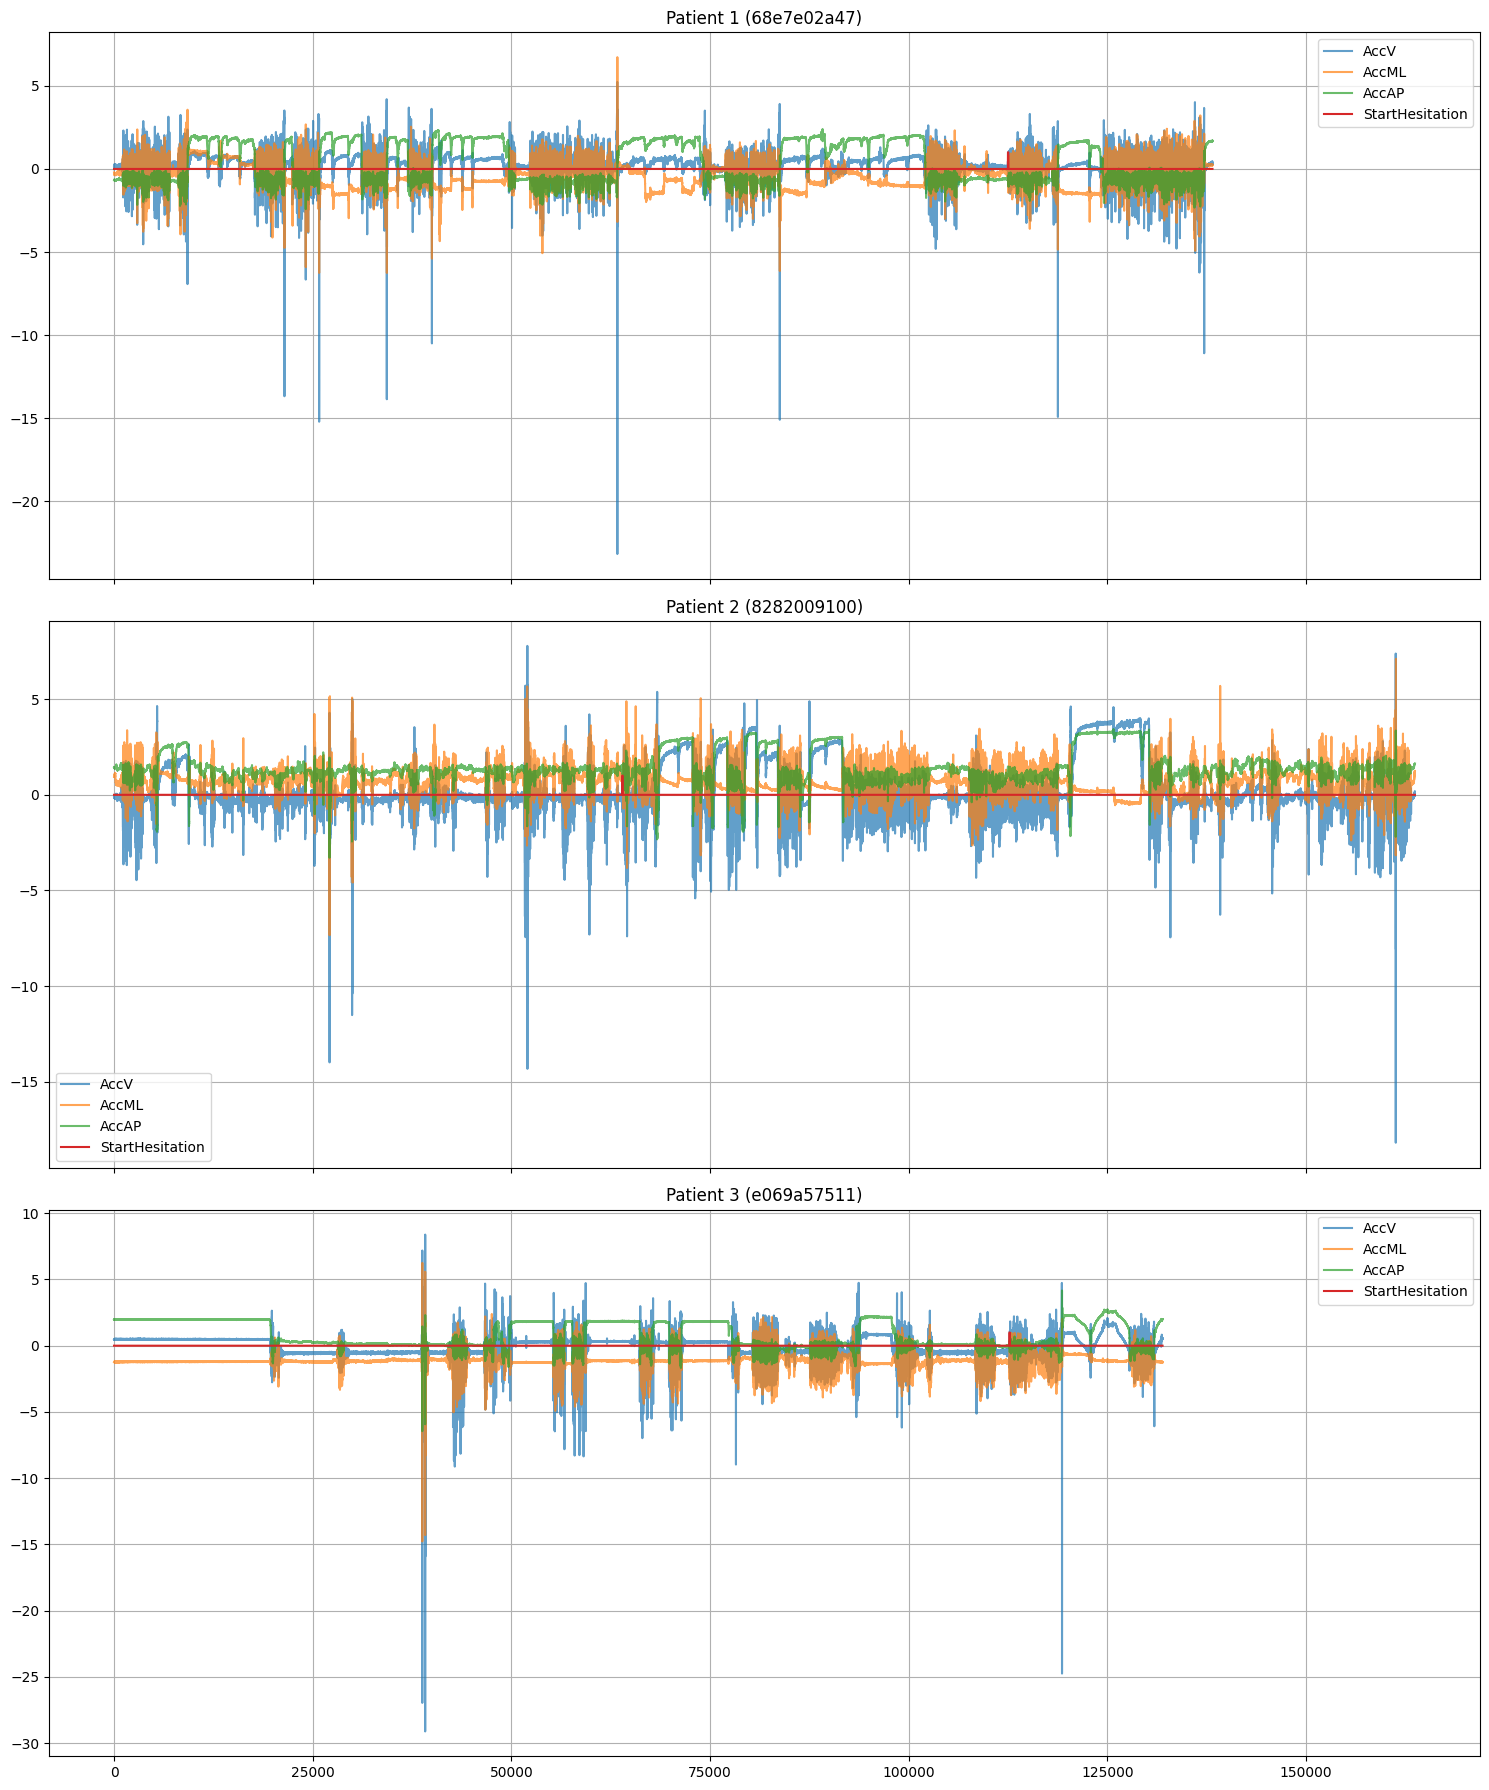

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 18), sharex=True)

# Patient 1
df1 = defog_df.query('PatientID == "68e7e02a47"')
ax1.plot(df1["SecondsFromStart"], df1["AccV"], label="AccV", alpha=0.7)
ax1.plot(df1["SecondsFromStart"], df1["AccML"], label="AccML", alpha=0.7)
ax1.plot(df1["SecondsFromStart"], df1["AccAP"], label="AccAP", alpha=0.7)
ax1.plot(df1["SecondsFromStart"], df1["StartHesitation"], label="StartHesitation")
ax1.set_title("Patient 1 (68e7e02a47)")
ax1.legend()
ax1.grid(True)

# Patient 2
df2 = defog_df.query('PatientID == "8282009100"')
ax2.plot(df2["SecondsFromStart"], df2["AccV"], label="AccV", alpha=0.7)
ax2.plot(df2["SecondsFromStart"], df2["AccML"], label="AccML", alpha=0.7)
ax2.plot(df2["SecondsFromStart"], df2["AccAP"], label="AccAP", alpha=0.7)
ax2.plot(df2["SecondsFromStart"], df2["StartHesitation"], label="StartHesitation")
ax2.set_title("Patient 2 (8282009100)")
ax2.legend()
ax2.grid(True)

# Patient 3
df3 = defog_df.query('PatientID == "e069a57511"')
ax3.plot(df3["SecondsFromStart"], df3["AccV"], label="AccV", alpha=0.7)
ax3.plot(df3["SecondsFromStart"], df3["AccML"], label="AccML", alpha=0.7)
ax3.plot(df3["SecondsFromStart"], df3["AccAP"], label="AccAP", alpha=0.7)
ax3.plot(df3["SecondsFromStart"], df3["StartHesitation"], label="StartHesitation")
ax3.set_title("Patient 3 (e069a57511)")
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()


### Graph Patient 1's AccV, AccML, AccAP on Separate Graphs

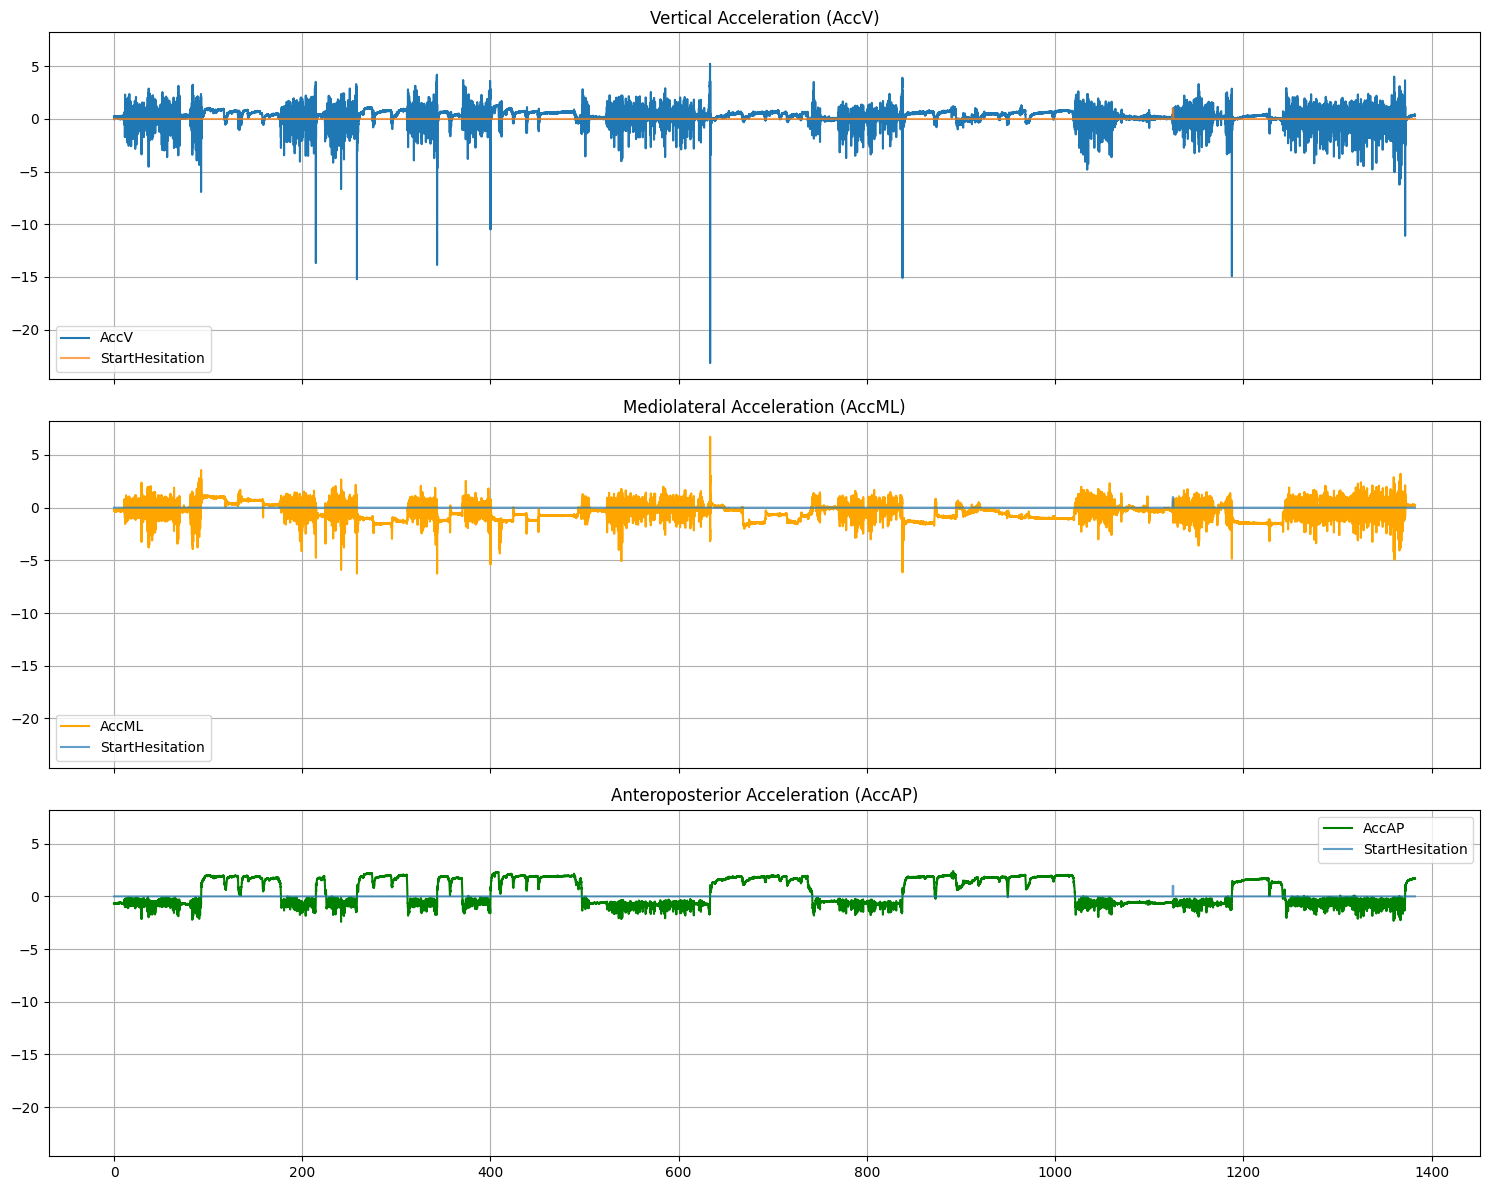

In [56]:
# Graph Patient 1 
df = defog_df.query(f'PatientID == "68e7e02a47"')
fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["SecondsFromStart"], df["AccV"], label="AccV")
ax_accV.plot(df['SecondsFromStart'], df['StartHesitation'], label='StartHesitation', alpha=0.7)

ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["SecondsFromStart"], df["AccML"], label="AccML", color="orange")
ax_accML.plot(df['SecondsFromStart'], df['StartHesitation'], label='StartHesitation', alpha=0.7)

ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["SecondsFromStart"], df["AccAP"], label="AccAP", color="green")
ax_accAP.plot(df['SecondsFromStart'], df['StartHesitation'], label='StartHesitation', alpha=0.7)

ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

plt.tight_layout()
plt.show()


### Zoom-In on Patient 1's Start Hestitation Event

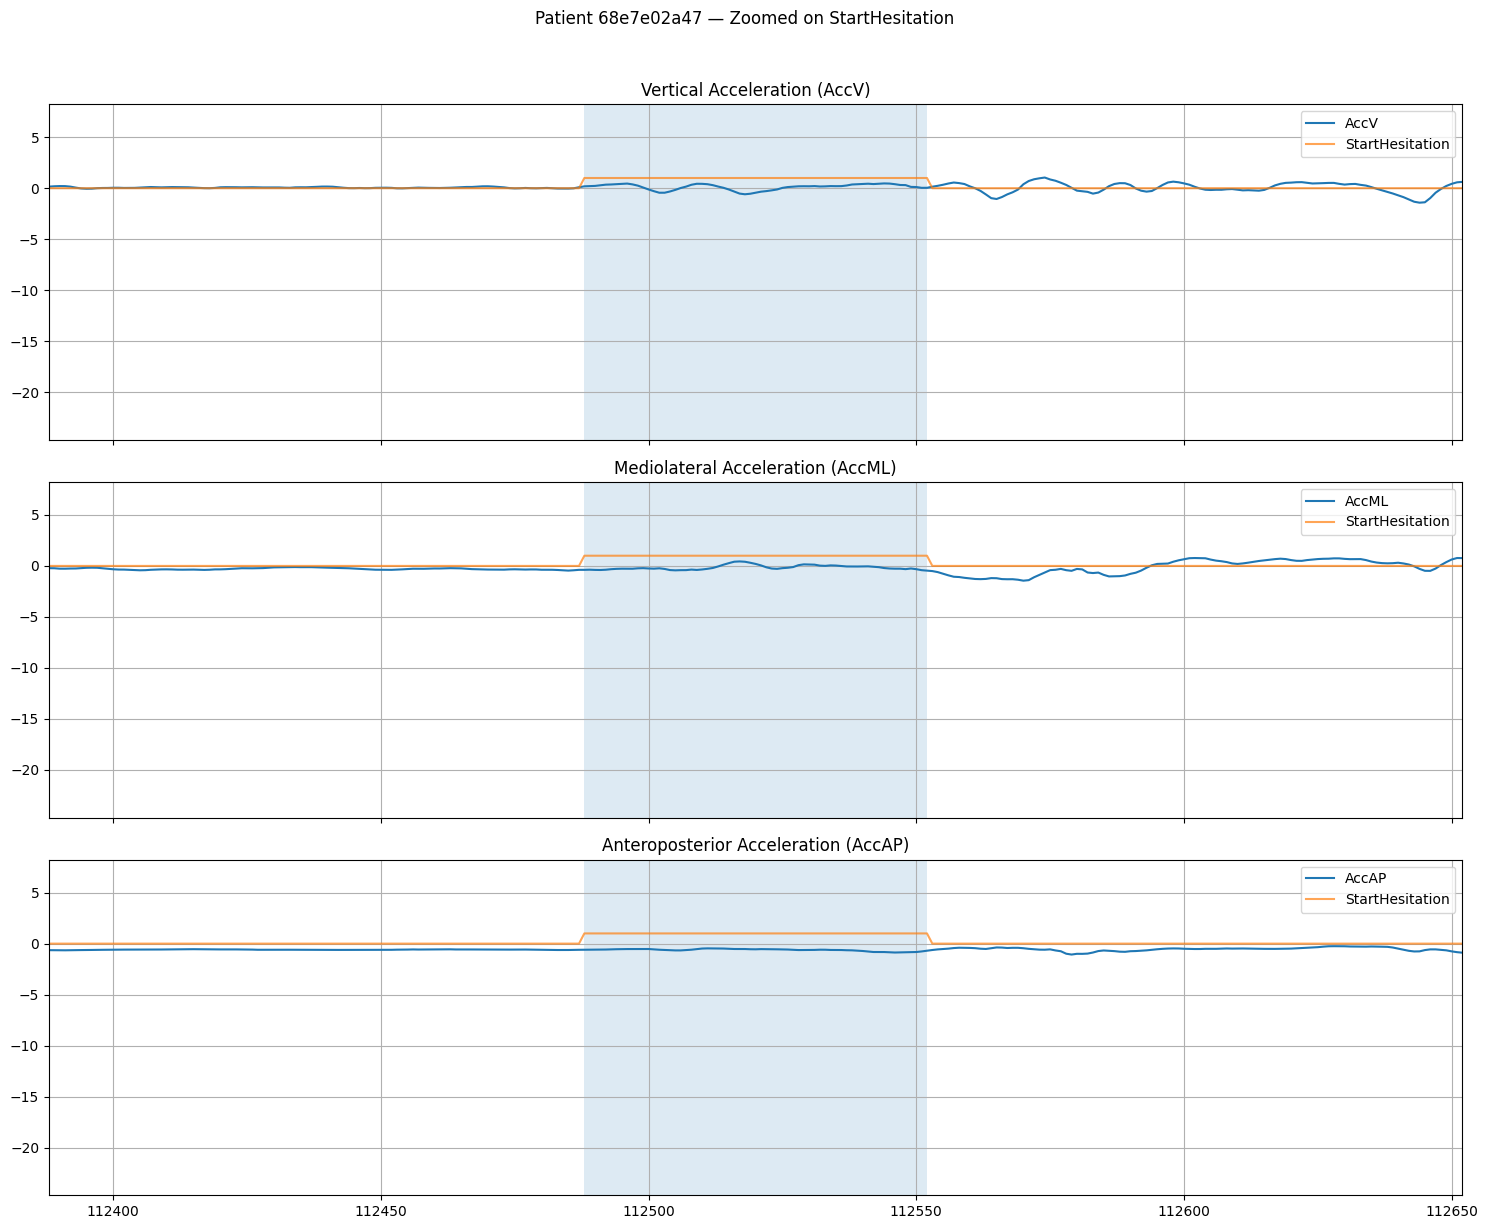

In [28]:
# Graph Patient 1
patient_id = "68e7e02a47"
df = defog_df.query('PatientID=="68e7e02a47"')

# --- compute zoom window around StartHesitation ---
event_times = df.loc[df["StartHesitation"] == 1, "Time"]
evt_min = event_times.min()
evt_max = event_times.max()
margin = 100  # seconds of padding on each side; tweak as needed
x_min, x_max = evt_min - margin, evt_max + margin

fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["Time"], df["AccV"], label="AccV")
ax_accV.plot(df["Time"], df["StartHesitation"], label="StartHesitation", alpha=0.7)
ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["Time"], df["AccML"], label="AccML")
ax_accML.plot(df["Time"], df["StartHesitation"], label="StartHesitation", alpha=0.7)
ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["Time"], df["AccAP"], label="AccAP")
ax_accAP.plot(df["Time"], df["StartHesitation"], label="StartHesitation", alpha=0.7)
ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

# --- apply the same x-limits (zoom) to all subplots ---
for ax in (ax_accV, ax_accML, ax_accAP):
    ax.set_xlim(x_min, x_max)
    # visually highlight the event window
    ax.axvspan(evt_min, evt_max, alpha=0.15)

plt.suptitle(f"Patient {patient_id} — Zoomed on StartHesitation", y=1.02)
plt.tight_layout()
plt.show()


### Graph Patient 2's Start Hesitation Event

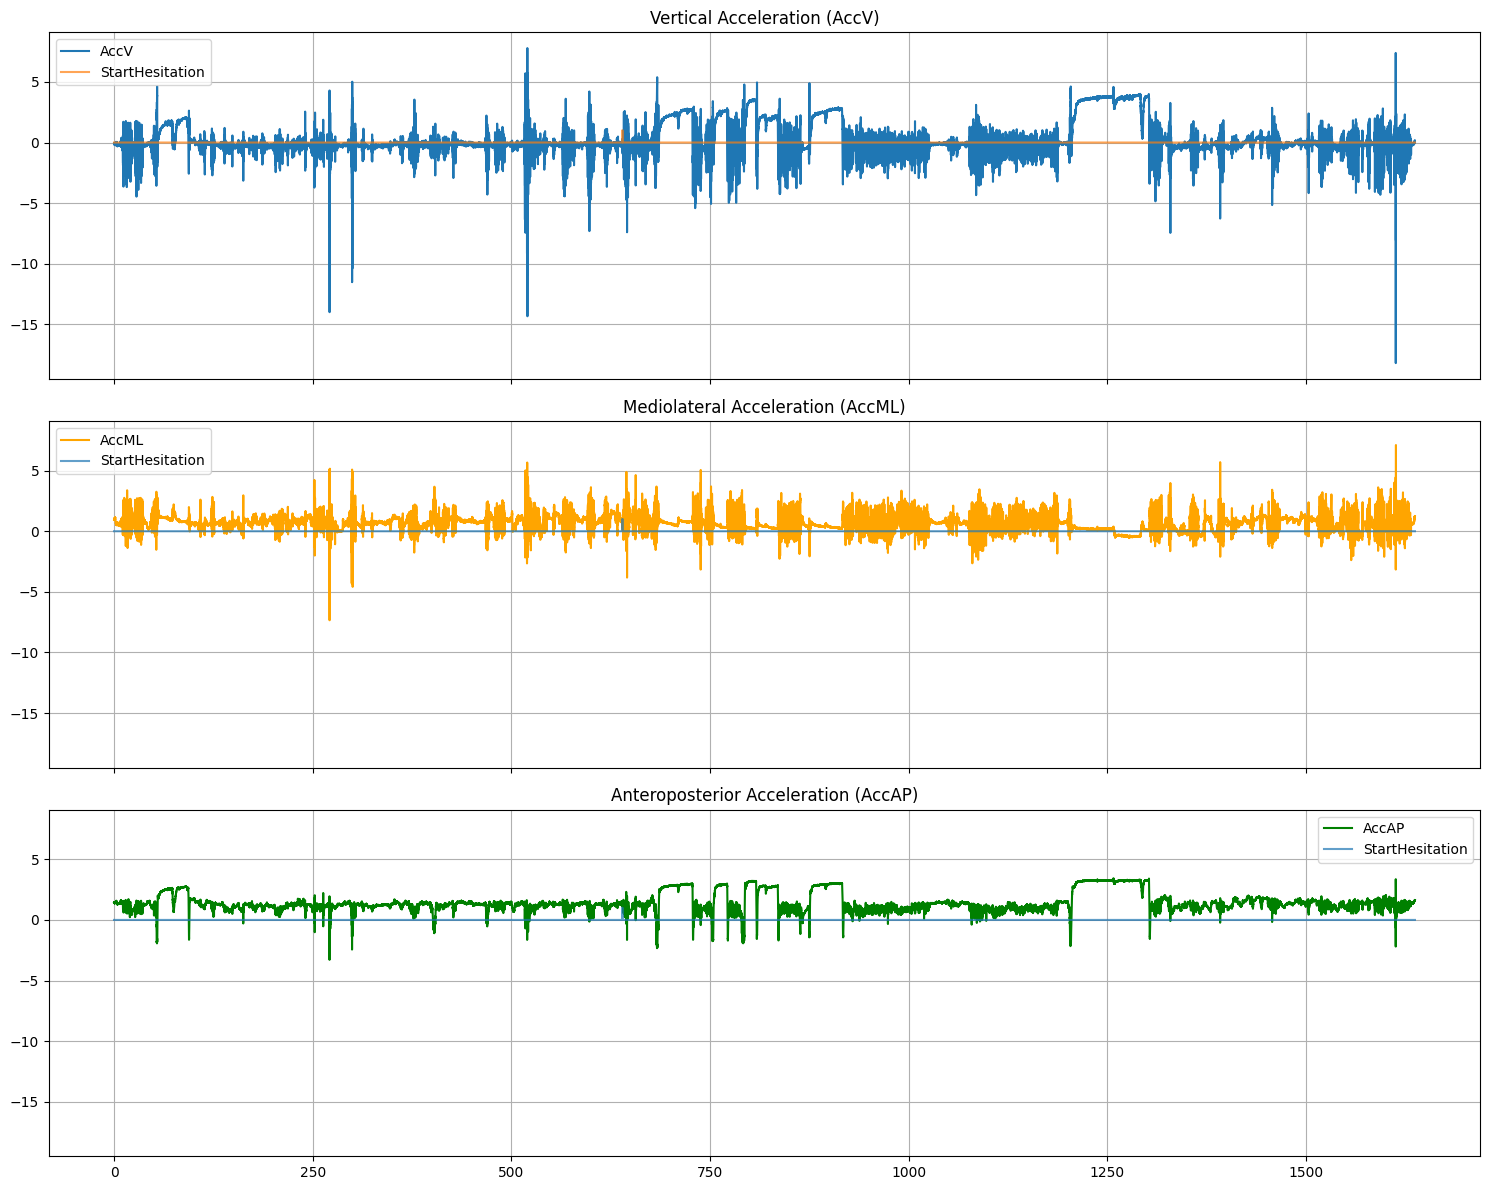

In [57]:
# Graph Patient 2
df = defog_df.query(f'PatientID == "8282009100"')
fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["SecondsFromStart"], df["AccV"], label="AccV")
ax_accV.plot(df['SecondsFromStart'], df['StartHesitation'], label='StartHesitation', alpha=0.7)

ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["SecondsFromStart"], df["AccML"], label="AccML", color="orange")
ax_accML.plot(df['SecondsFromStart'], df['StartHesitation'], label='StartHesitation', alpha=0.7)

ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["SecondsFromStart"], df["AccAP"], label="AccAP", color="green")
ax_accAP.plot(df['SecondsFromStart'], df['StartHesitation'], label='StartHesitation', alpha=0.7)

ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

plt.tight_layout()
plt.show()


### Zoom-In on Patient 2's Start Hestitation Event

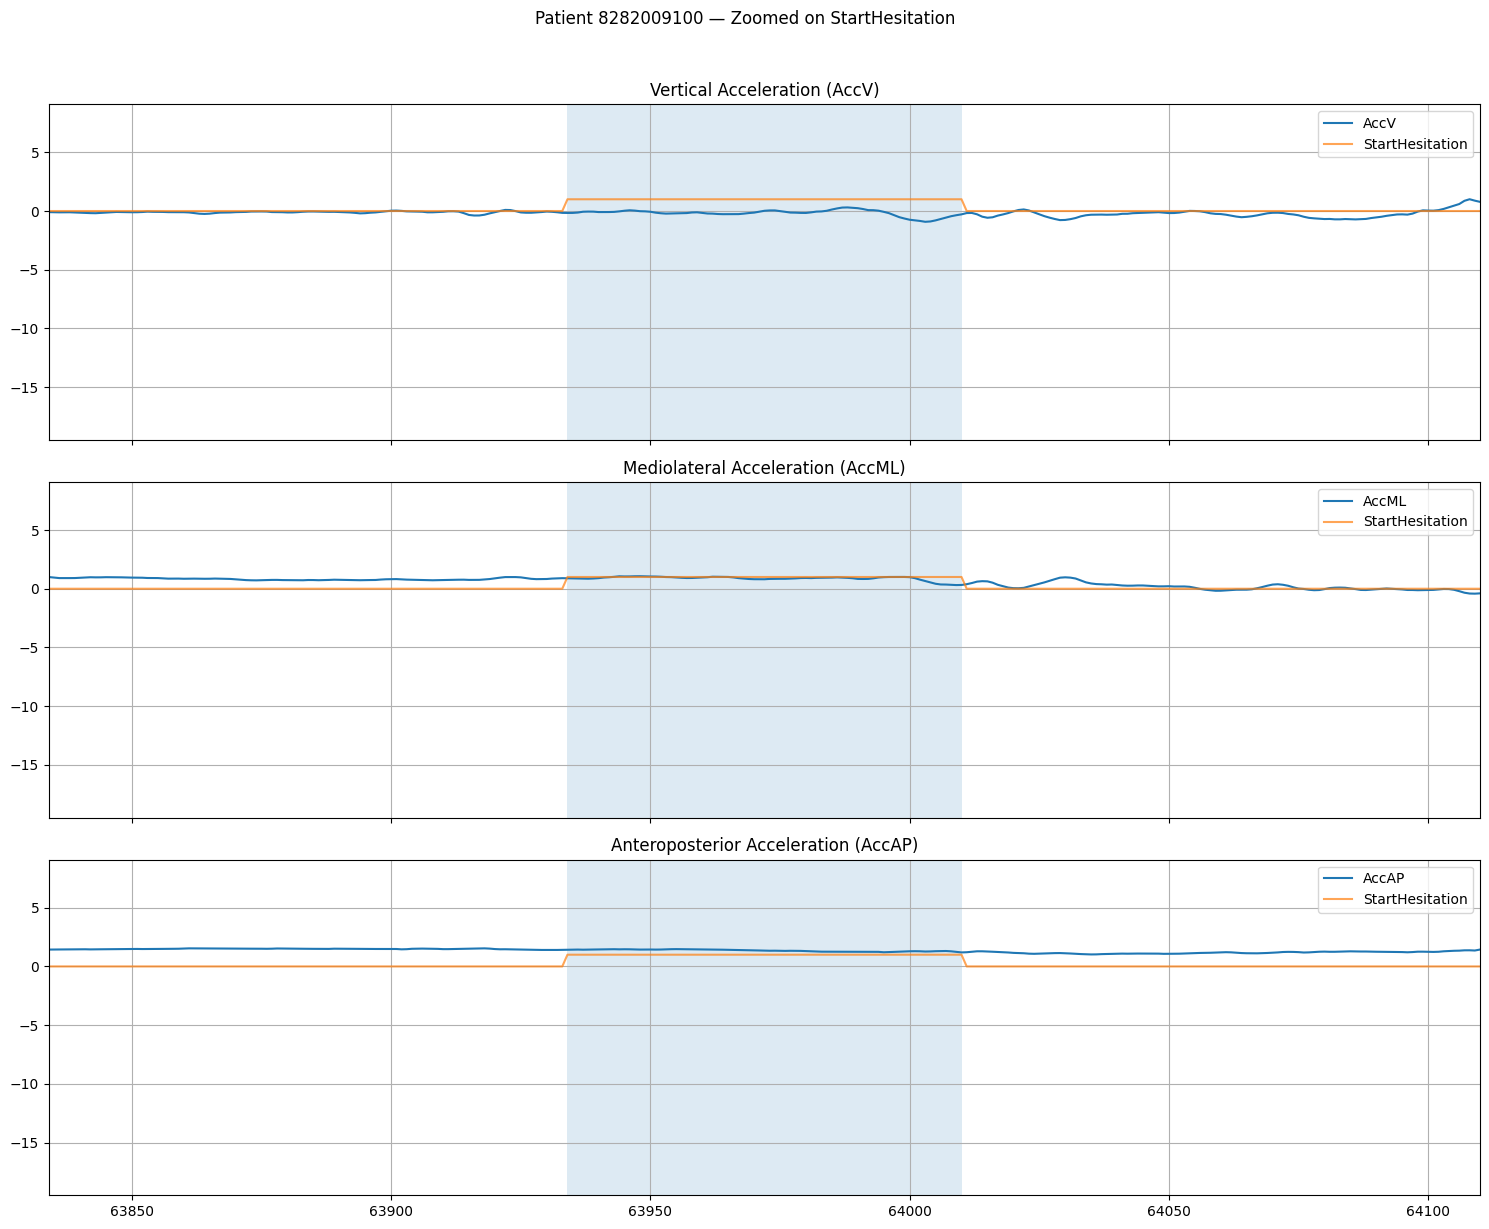

In [33]:
# Graph Patient 2
patient_id = "8282009100"
df = defog_df.query(f'PatientID == "8282009100"')

# --- compute zoom window around StartHesitation ---
event_times = df.loc[df["StartHesitation"] == 1, "Time"]
evt_min = event_times.min()
evt_max = event_times.max()
margin = 100  # seconds of padding on each side; tweak as needed
x_min, x_max = evt_min - margin, evt_max + margin

fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["Time"], df["AccV"], label="AccV")
ax_accV.plot(df["Time"], df["StartHesitation"], label="StartHesitation", alpha=0.7)
ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["Time"], df["AccML"], label="AccML")
ax_accML.plot(df["Time"], df["StartHesitation"], label="StartHesitation", alpha=0.7)
ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["Time"], df["AccAP"], label="AccAP")
ax_accAP.plot(df["Time"], df["StartHesitation"], label="StartHesitation", alpha=0.7)
ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

# --- apply the same x-limits (zoom) to all subplots ---
for ax in (ax_accV, ax_accML, ax_accAP):
    ax.set_xlim(x_min, x_max)
    # visually highlight the event window
    ax.axvspan(evt_min, evt_max, alpha=0.15)

plt.suptitle(f"Patient {patient_id} — Zoomed on StartHesitation", y=1.02)
plt.tight_layout()
plt.show()


### Graph Patient 3's Start Hesitation Event

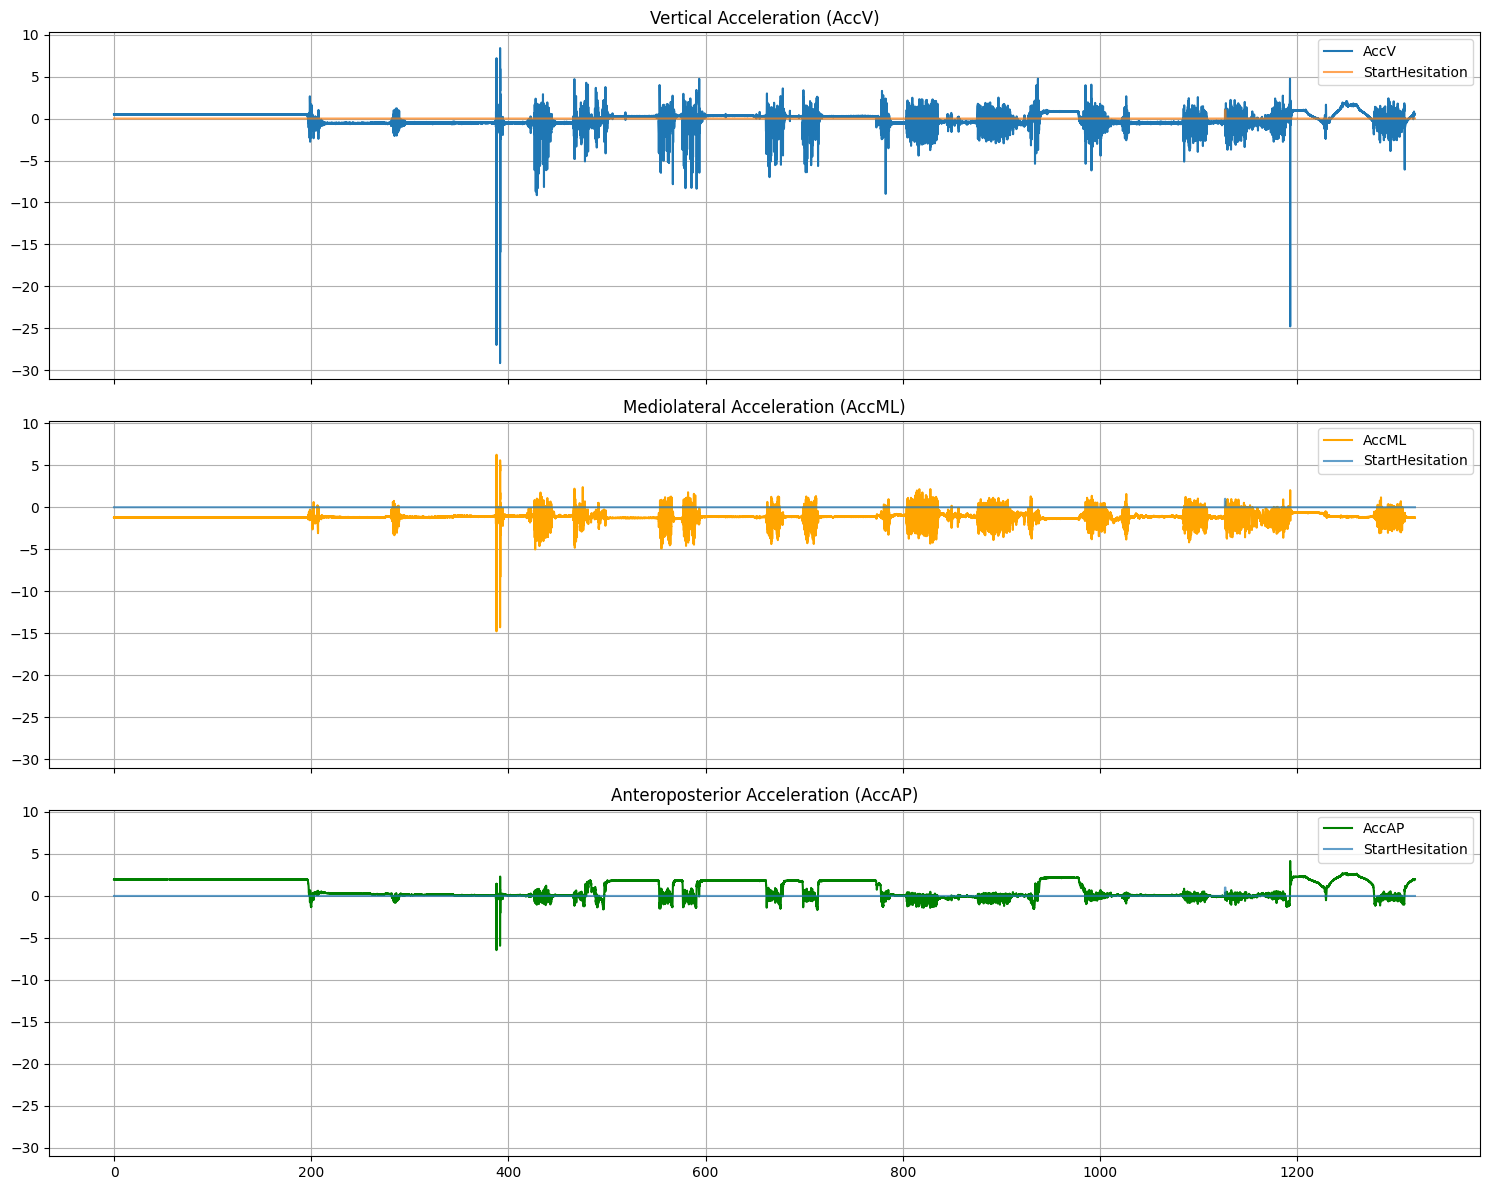

In [58]:
# Graph Patient 2
df = defog_df.query(f'PatientID == "e069a57511"')
fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["SecondsFromStart"], df["AccV"], label="AccV")
ax_accV.plot(df['SecondsFromStart'], df['StartHesitation'], label='StartHesitation', alpha=0.7)

ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["SecondsFromStart"], df["AccML"], label="AccML", color="orange")
ax_accML.plot(df['SecondsFromStart'], df['StartHesitation'], label='StartHesitation', alpha=0.7)

ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["SecondsFromStart"], df["AccAP"], label="AccAP", color="green")
ax_accAP.plot(df['SecondsFromStart'], df['StartHesitation'], label='StartHesitation', alpha=0.7)

ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

plt.tight_layout()
plt.show()


### Zoom-In on Patient 3's Start Hestitation Event

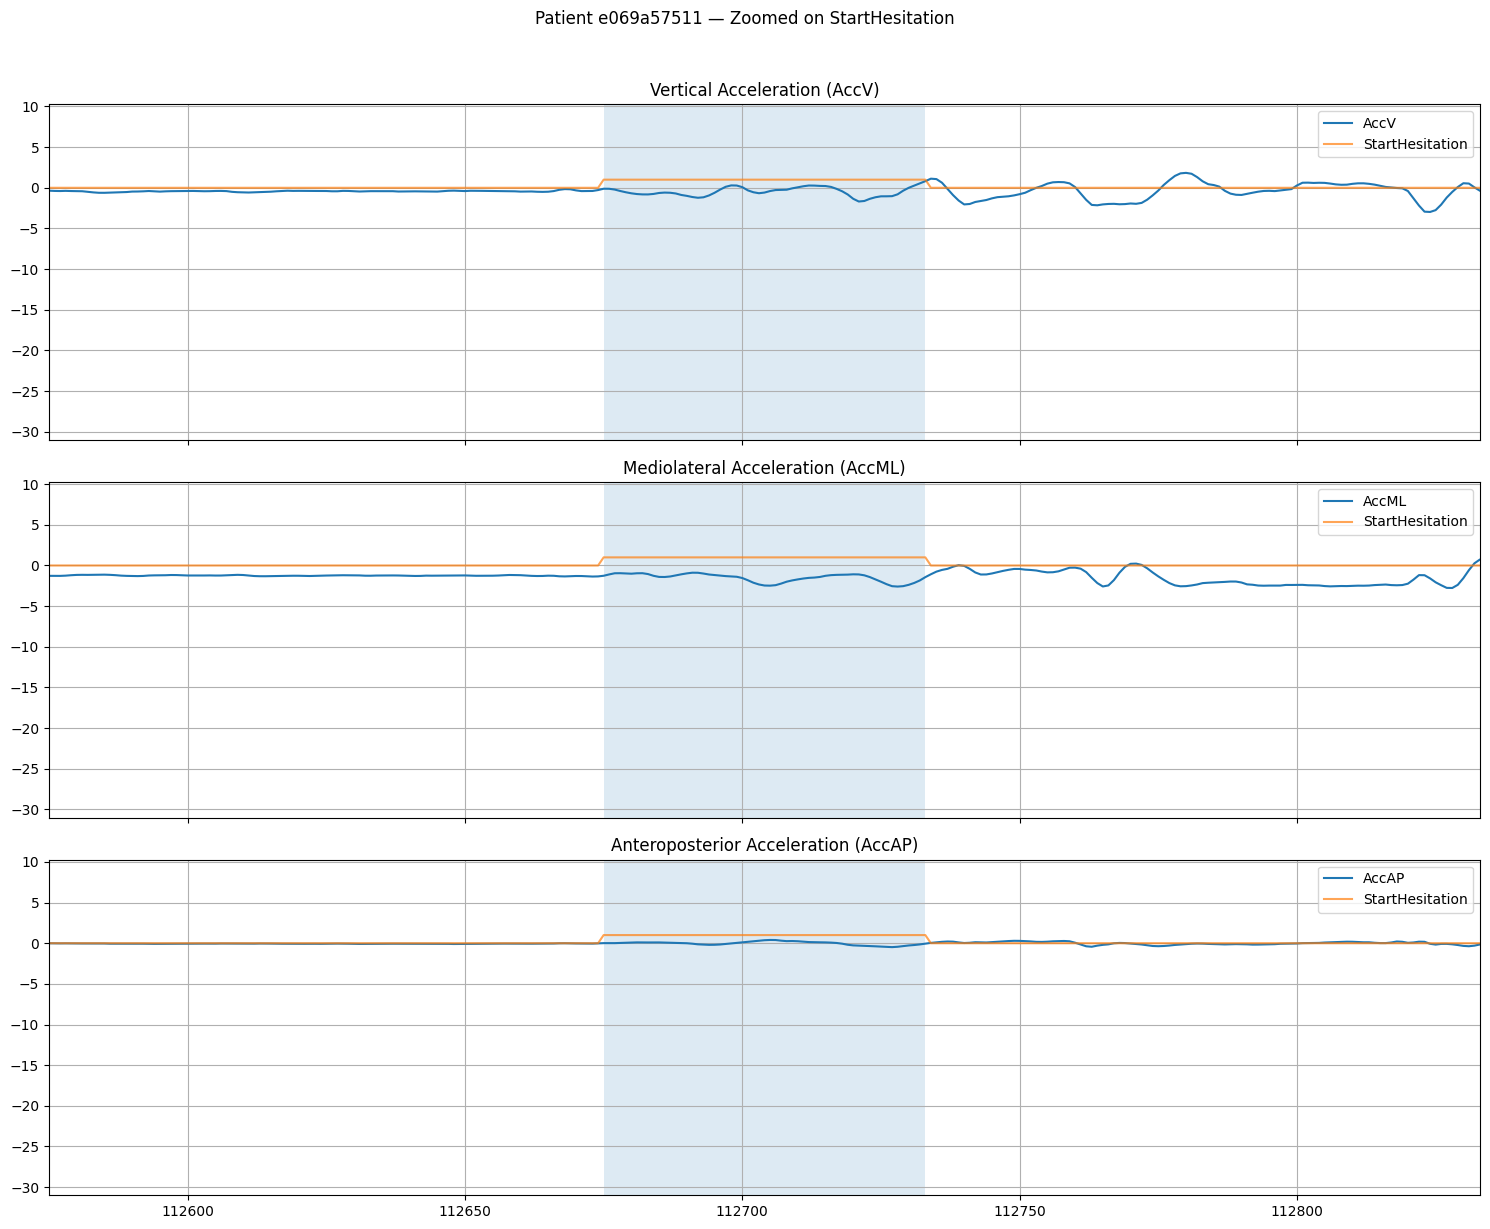

In [46]:
# Graph Patient 3
patient_id = "e069a57511"
df = defog_df.query(f'PatientID == "e069a57511"')

# --- compute zoom window around StartHesitation ---
event_times = df.loc[df["StartHesitation"] == 1, "Time"]
evt_min = event_times.min()
evt_max = event_times.max()
margin = 100  # seconds of padding on each side; tweak as needed
x_min, x_max = evt_min - margin, evt_max + margin

fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["Time"], df["AccV"], label="AccV")
ax_accV.plot(df["Time"], df["StartHesitation"], label="StartHesitation", alpha=0.7)
ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["Time"], df["AccML"], label="AccML")
ax_accML.plot(df["Time"], df["StartHesitation"], label="StartHesitation", alpha=0.7)
ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["Time"], df["AccAP"], label="AccAP")
ax_accAP.plot(df["Time"], df["StartHesitation"], label="StartHesitation", alpha=0.7)
ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

# --- apply the same x-limits (zoom) to all subplots ---
for ax in (ax_accV, ax_accML, ax_accAP):
    ax.set_xlim(x_min, x_max)
    # visually highlight the event window
    ax.axvspan(evt_min, evt_max, alpha=0.15)

plt.suptitle(f"Patient {patient_id} — Zoomed on StartHesitation", y=1.02)
plt.tight_layout()
plt.show()


### Acceleration Patterns Analyzed During Start Hesitation:
- **AccV (Vertical acceleration)**
    - Up and down oscillations
- **AccML (Mediolateral / side-to-side)**
    - Up and down oscillations
- **AccAP (Anteroposterior / forward–backward)**
    - Normally smooth

## Acceleration v.s. Time for Patients w/ Turn Events
- Patients with Turn: ['be9d33541d' '4c3aa8ea6e' '18e7abc37e']

### Graph Patient 1's Turn Event

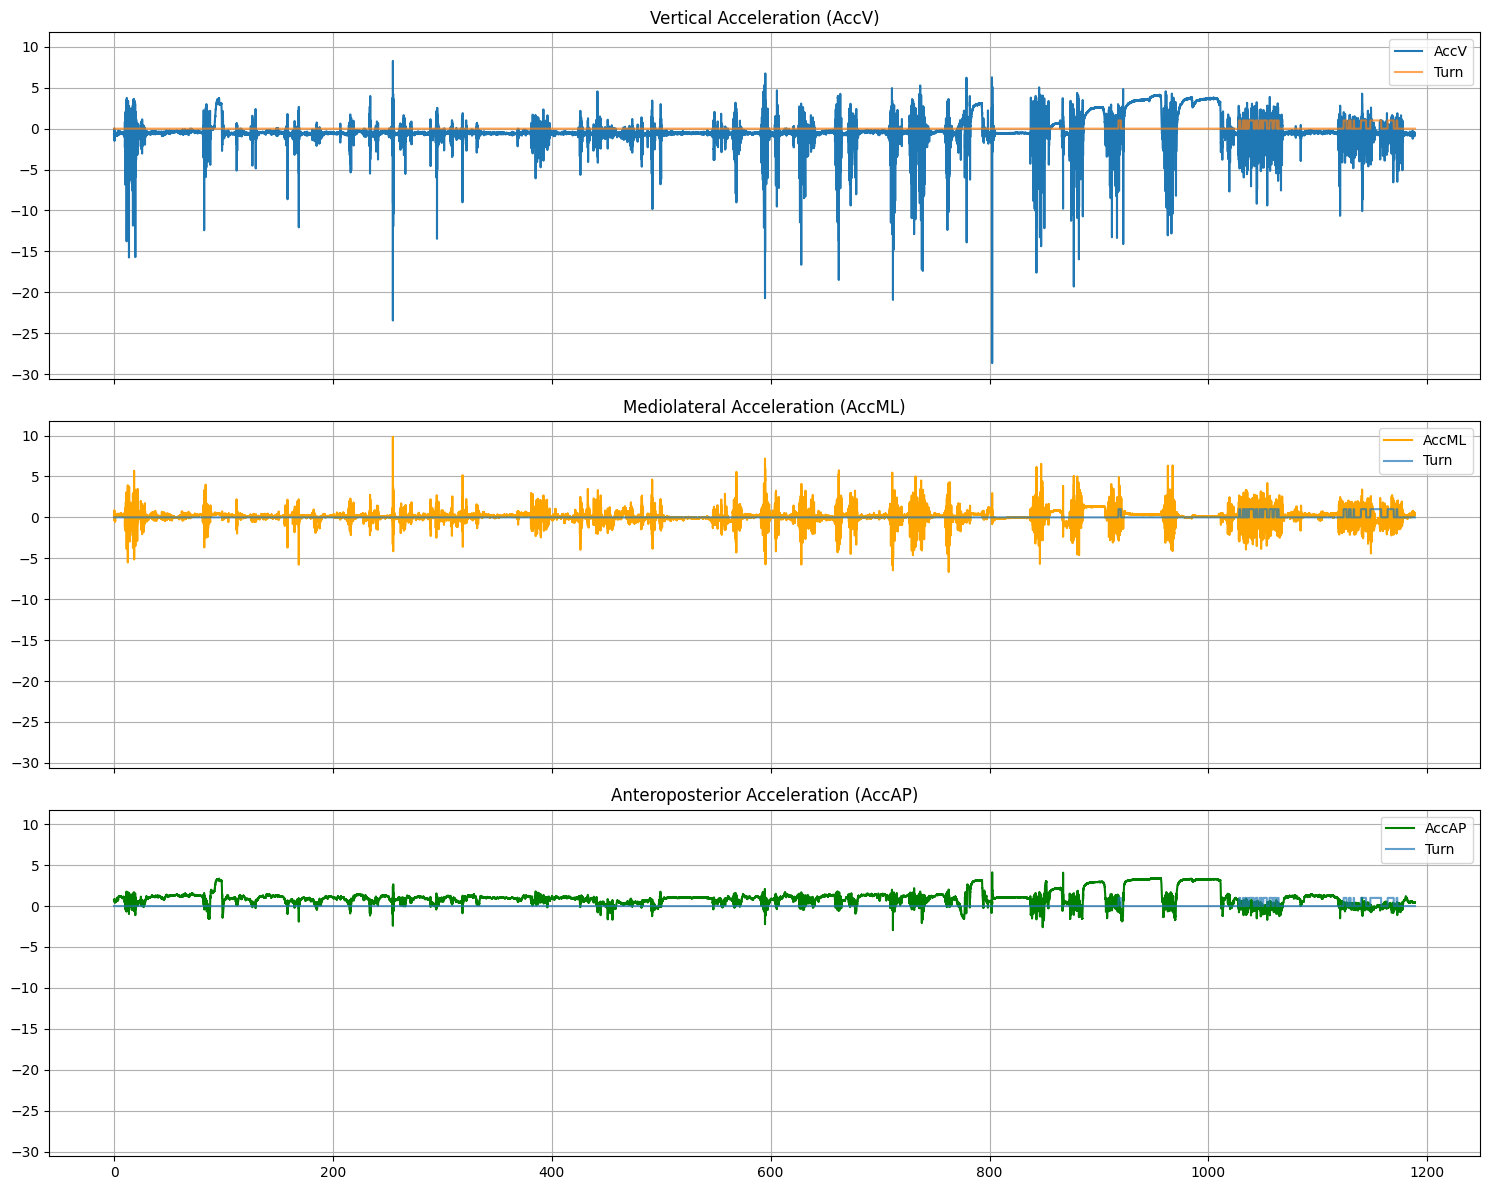

In [37]:
# Graph Patient 1 
df = defog_df.query(f'PatientID == "be9d33541d"')

fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["SecondsFromStart"], df["AccV"], label="AccV")
ax_accV.plot(df['SecondsFromStart'], df['Turn'], label='Turn', alpha=0.7)

ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["SecondsFromStart"], df["AccML"], label="AccML", color="orange")
ax_accML.plot(df['SecondsFromStart'], df['Turn'], label='Turn', alpha=0.7)

ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["SecondsFromStart"], df["AccAP"], label="AccAP", color="green")
ax_accAP.plot(df['SecondsFromStart'], df['Turn'], label='Turn', alpha=0.7)

ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

plt.tight_layout()
plt.show()


### Graph Patient 2's Turn Event

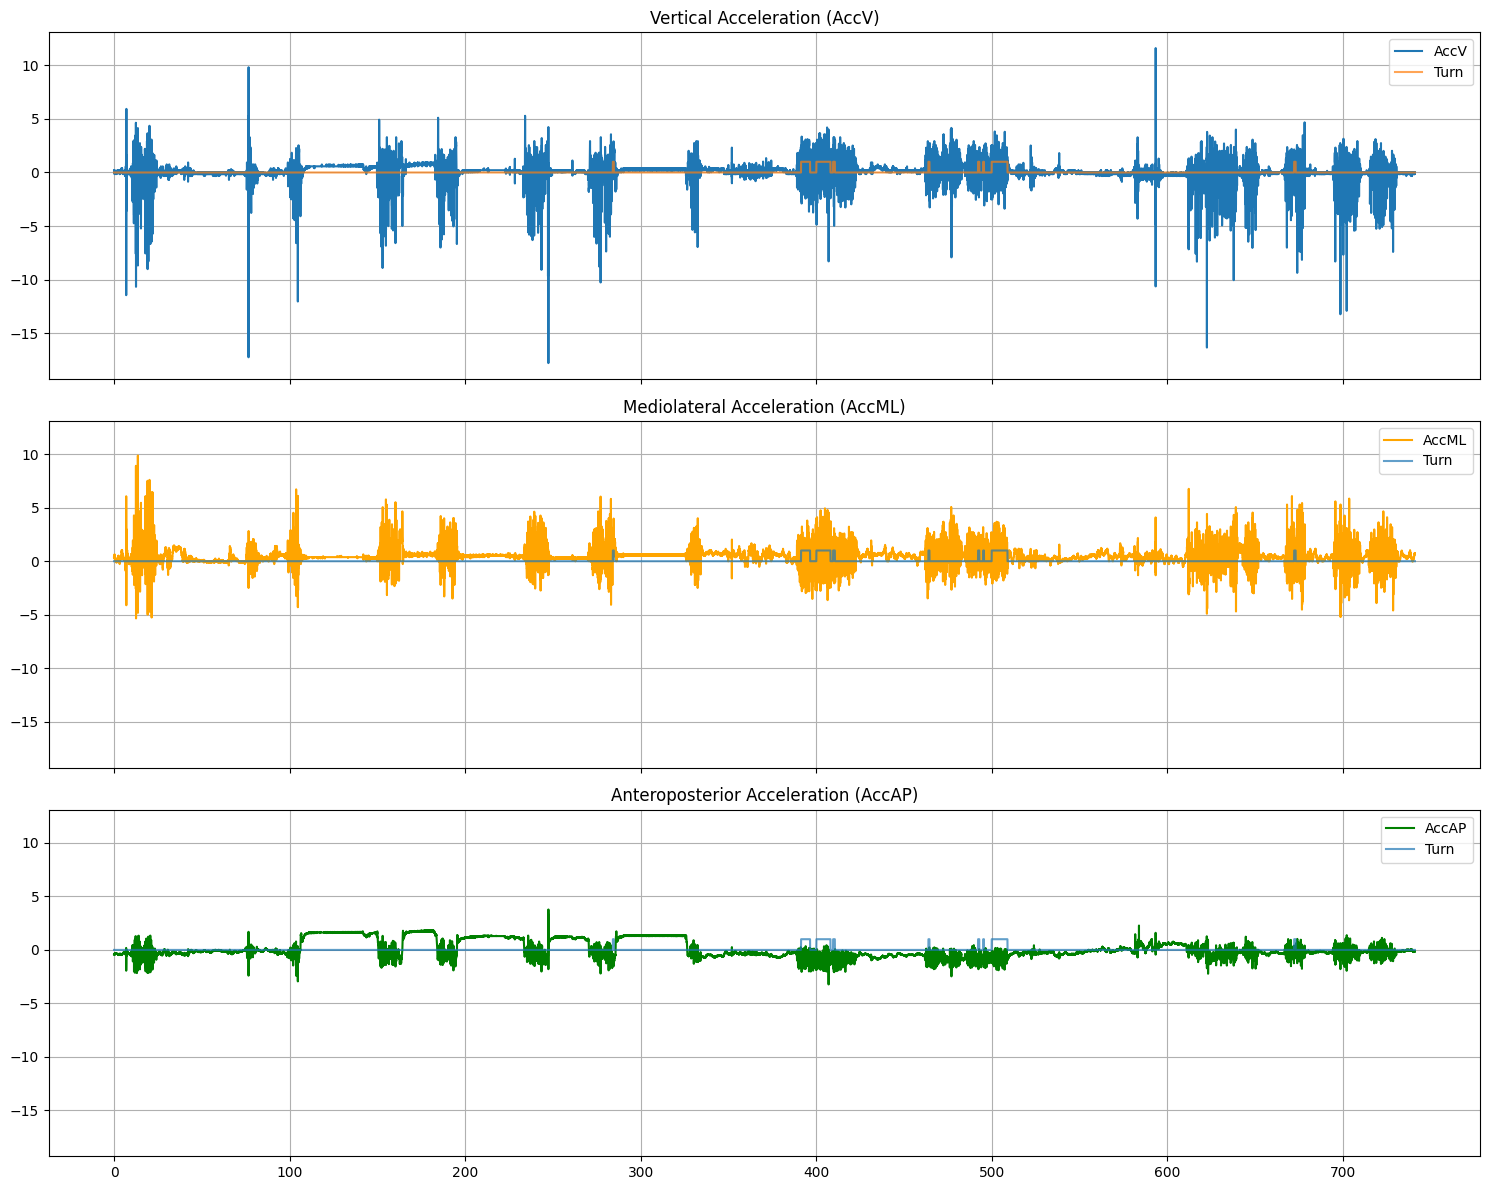

In [38]:
# Graph Patient 1 
df = defog_df.query(f'PatientID == "4c3aa8ea6e"')

fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["SecondsFromStart"], df["AccV"], label="AccV")
ax_accV.plot(df['SecondsFromStart'], df['Turn'], label='Turn', alpha=0.7)

ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["SecondsFromStart"], df["AccML"], label="AccML", color="orange")
ax_accML.plot(df['SecondsFromStart'], df['Turn'], label='Turn', alpha=0.7)

ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["SecondsFromStart"], df["AccAP"], label="AccAP", color="green")
ax_accAP.plot(df['SecondsFromStart'], df['Turn'], label='Turn', alpha=0.7)

ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

plt.tight_layout()
plt.show()


### Graph Patient 3's Turn Event

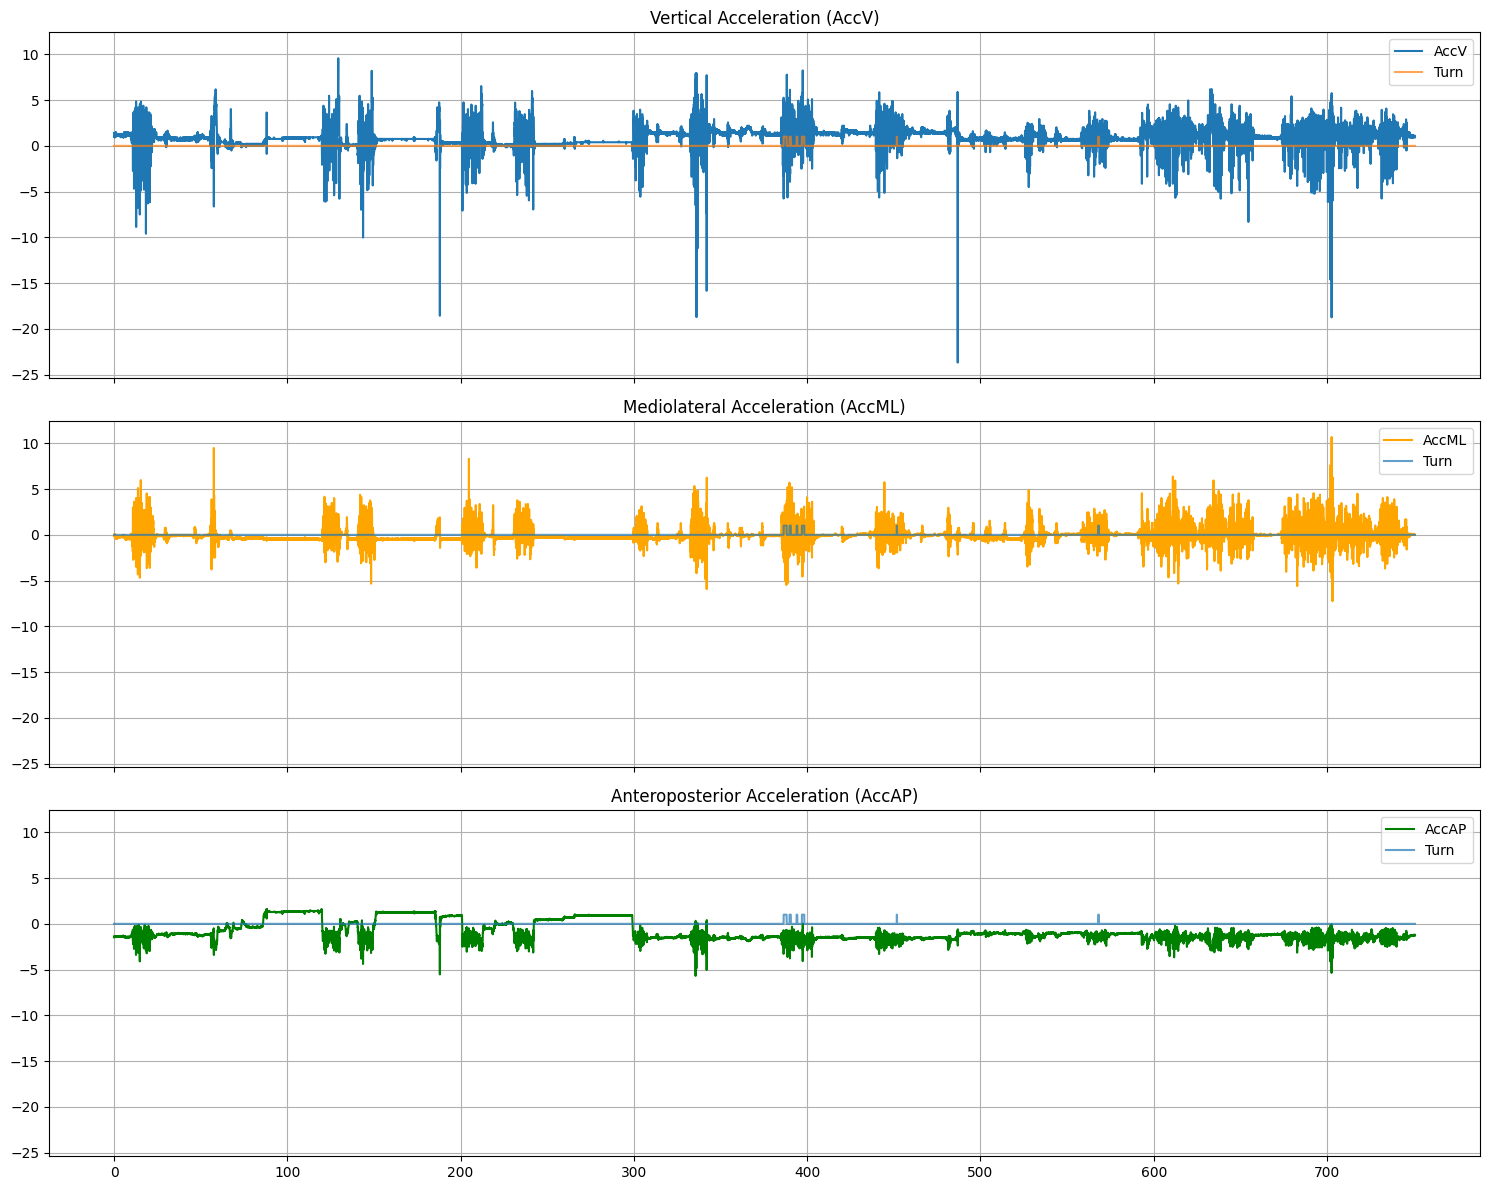

In [39]:
# Graph Patient 1 
df = defog_df.query(f'PatientID == "18e7abc37e"')

fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["SecondsFromStart"], df["AccV"], label="AccV")
ax_accV.plot(df['SecondsFromStart'], df['Turn'], label='Turn', alpha=0.7)

ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["SecondsFromStart"], df["AccML"], label="AccML", color="orange")
ax_accML.plot(df['SecondsFromStart'], df['Turn'], label='Turn', alpha=0.7)

ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["SecondsFromStart"], df["AccAP"], label="AccAP", color="green")
ax_accAP.plot(df['SecondsFromStart'], df['Turn'], label='Turn', alpha=0.7)

ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

plt.tight_layout()
plt.show()


### Acceleration Patterns Analyzed During Turn:
- **AccV (Vertical acceleration)**
    - Up and down oscillations
- **AccML (Mediolateral / side-to-side)**
    - Up and down oscillations
- **AccAP (Anteroposterior / forward–backward)**
    - Backwards motion (below 0)

## Acceleration v.s. Time for Patients w/ Walking Events
- Patients with Walking: ['be9d33541d' '4c3aa8ea6e' 'e642d9ea5f']

### Graph Patient 1's Walking Event

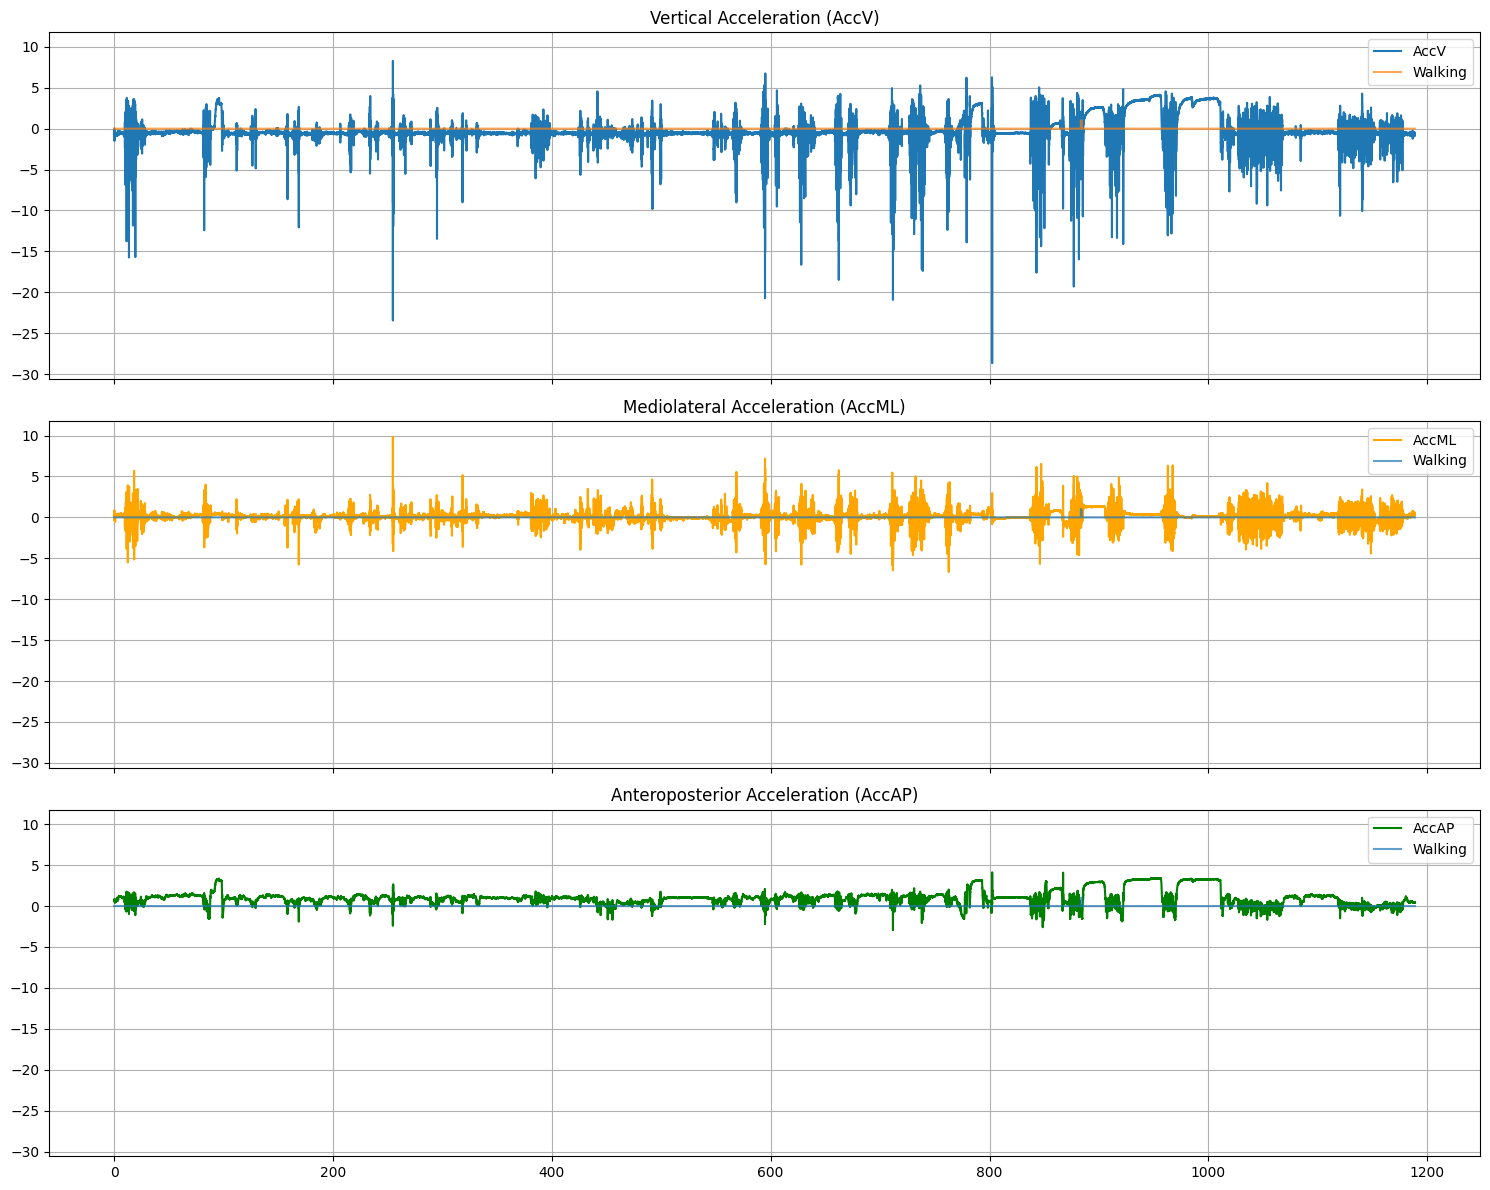

In [41]:
# Graph Patient 1 
df = defog_df.query(f'PatientID == "be9d33541d"')

fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["SecondsFromStart"], df["AccV"], label="AccV")
ax_accV.plot(df['SecondsFromStart'], df['Walking'], label='Walking', alpha=0.7)

ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["SecondsFromStart"], df["AccML"], label="AccML", color="orange")
ax_accML.plot(df['SecondsFromStart'], df['Walking'], label='Walking', alpha=0.7)

ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["SecondsFromStart"], df["AccAP"], label="AccAP", color="green")
ax_accAP.plot(df['SecondsFromStart'], df['Walking'], label='Walking', alpha=0.7)

ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

plt.tight_layout()
plt.show()


### Graph Patient 2's Walking Event

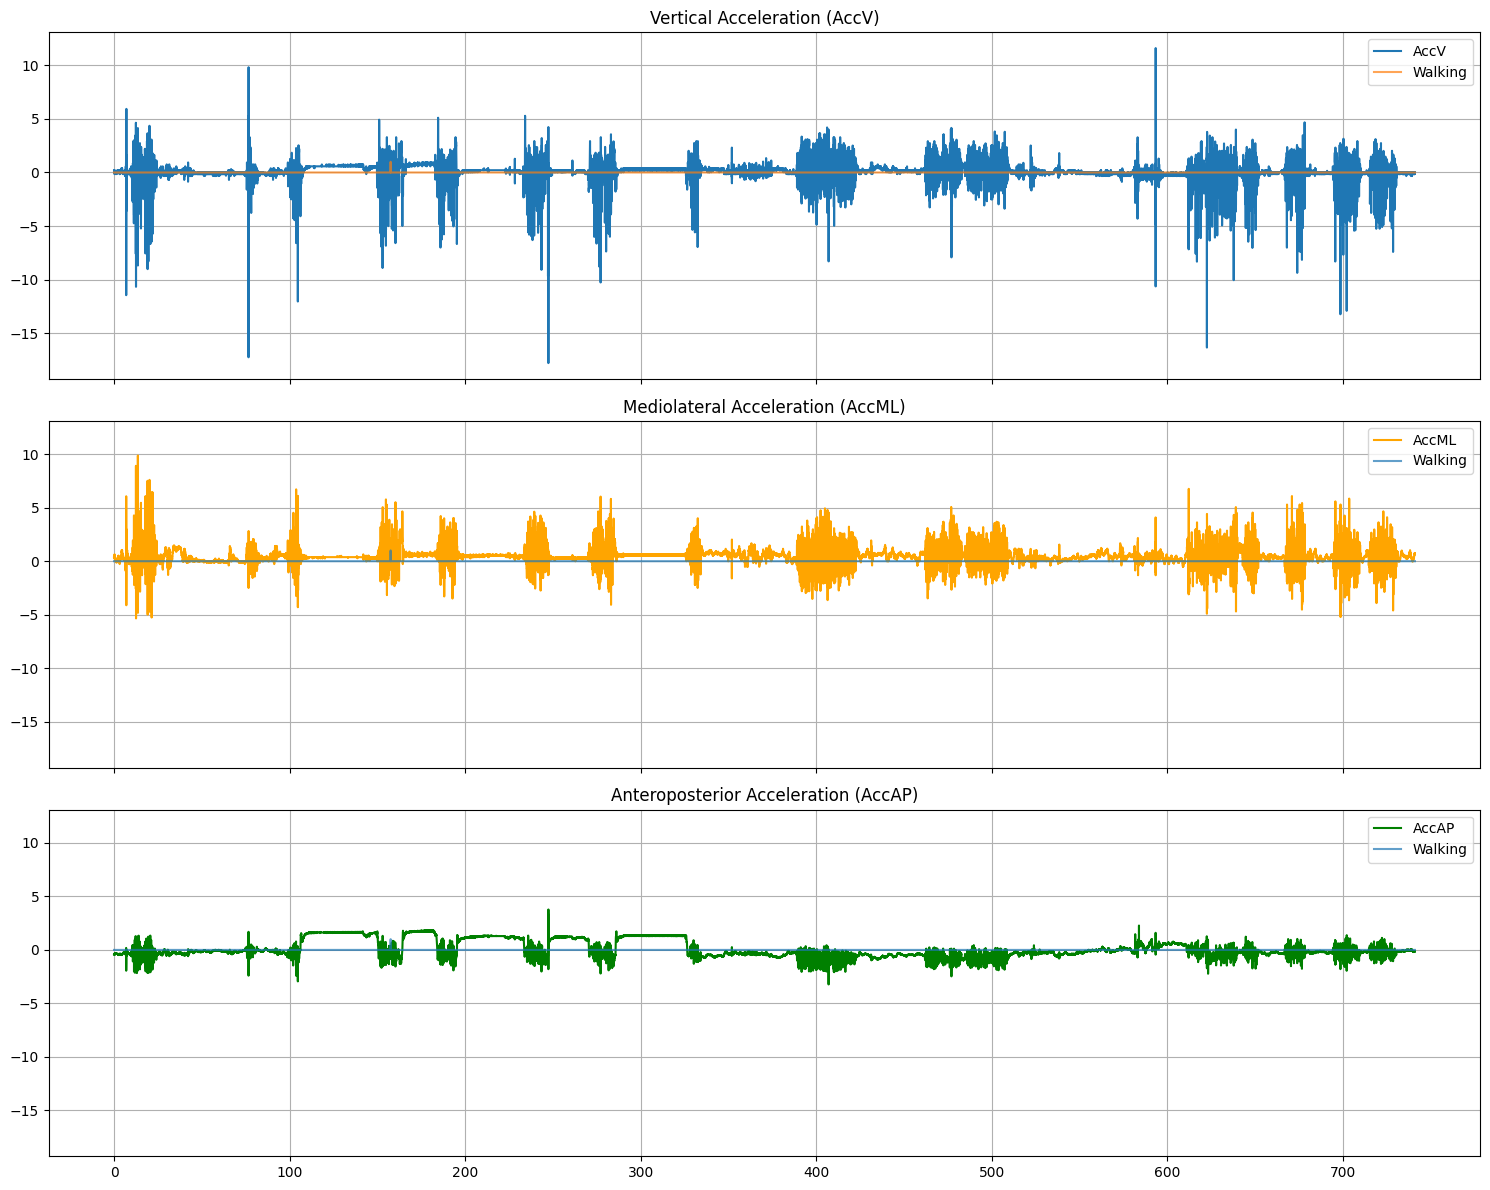

In [42]:
# Graph Patient 2 
df = defog_df.query(f'PatientID == "4c3aa8ea6e"')

fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["SecondsFromStart"], df["AccV"], label="AccV")
ax_accV.plot(df['SecondsFromStart'], df['Walking'], label='Walking', alpha=0.7)

ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["SecondsFromStart"], df["AccML"], label="AccML", color="orange")
ax_accML.plot(df['SecondsFromStart'], df['Walking'], label='Walking', alpha=0.7)

ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["SecondsFromStart"], df["AccAP"], label="AccAP", color="green")
ax_accAP.plot(df['SecondsFromStart'], df['Walking'], label='Walking', alpha=0.7)

ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

plt.tight_layout()
plt.show()


### Graph Patient 3's Walking Event

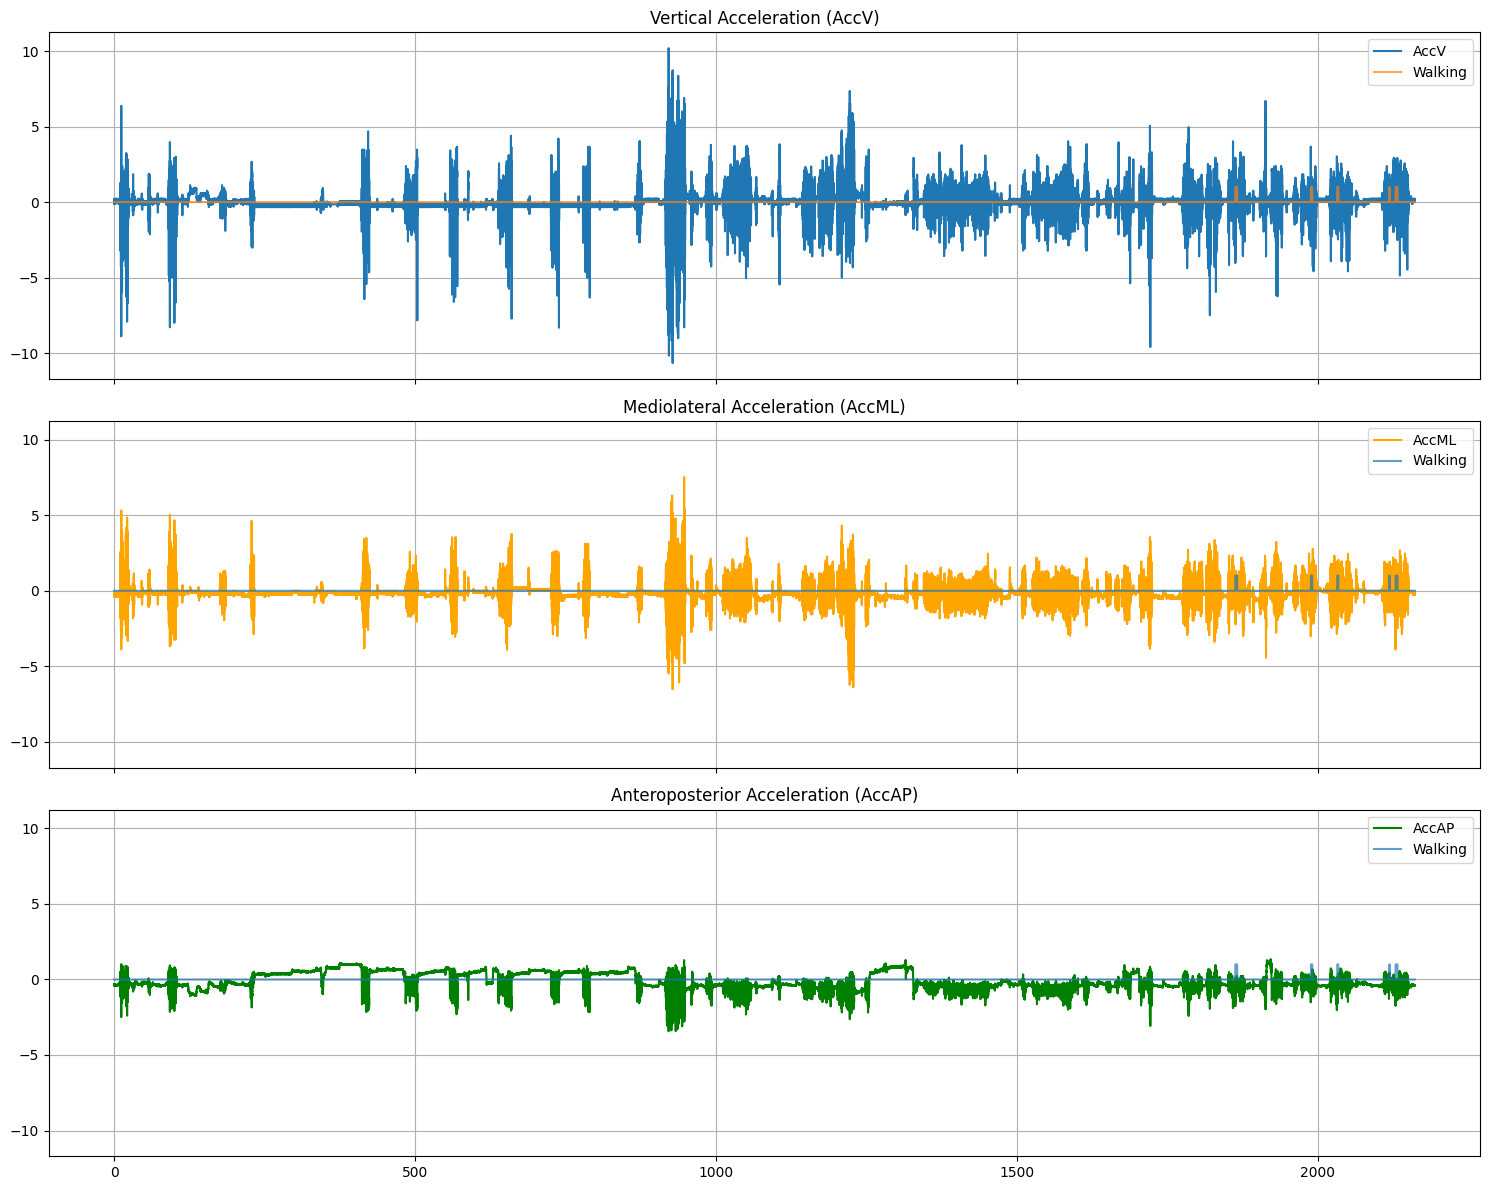

In [43]:
# Graph Patient 3
df = defog_df.query(f'PatientID == "e642d9ea5f"')

fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["SecondsFromStart"], df["AccV"], label="AccV")
ax_accV.plot(df['SecondsFromStart'], df['Walking'], label='Walking', alpha=0.7)

ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["SecondsFromStart"], df["AccML"], label="AccML", color="orange")
ax_accML.plot(df['SecondsFromStart'], df['Walking'], label='Walking', alpha=0.7)

ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["SecondsFromStart"], df["AccAP"], label="AccAP", color="green")
ax_accAP.plot(df['SecondsFromStart'], df['Walking'], label='Walking', alpha=0.7)

ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

plt.tight_layout()
plt.show()


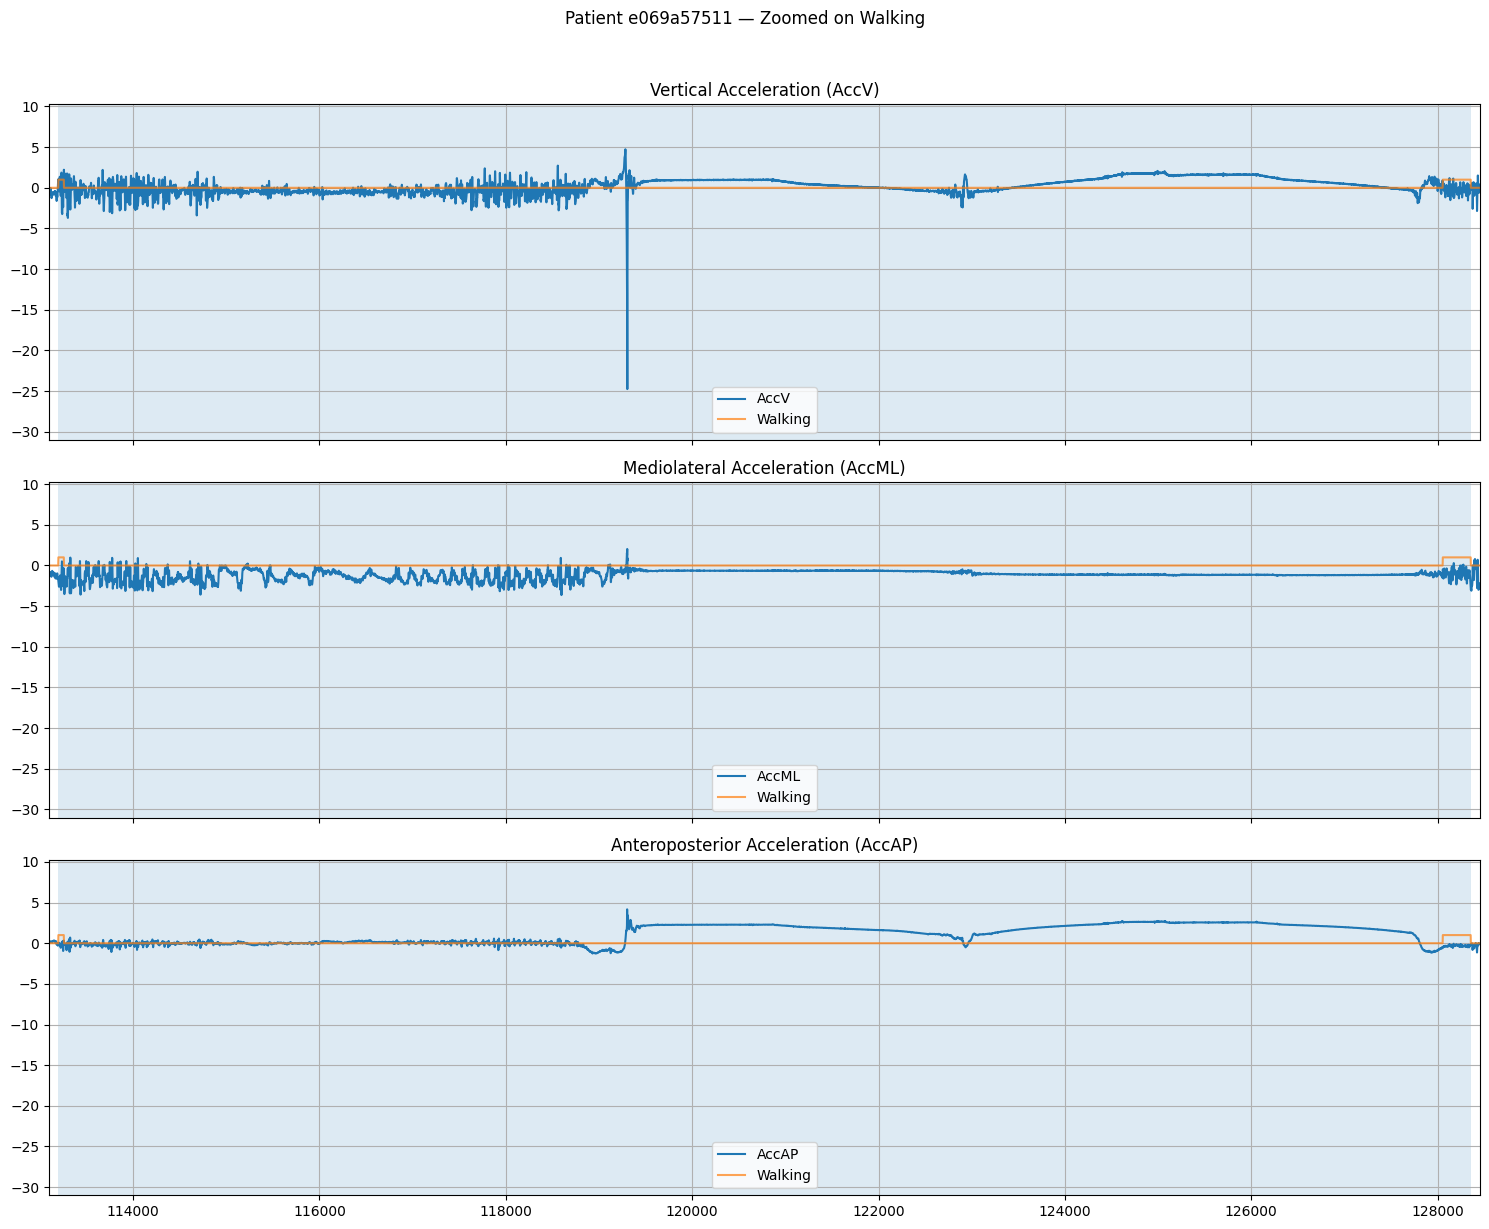

In [47]:
# Graph Patient 3
patient_id = "e069a57511"
df = defog_df.query(f'PatientID == "e069a57511"')

# --- compute zoom window around StartHesitation ---
event_times = df.loc[df["Walking"] == 1, "Time"]
evt_min = event_times.min()
evt_max = event_times.max()
margin = 100  # seconds of padding on each side; tweak as needed
x_min, x_max = evt_min - margin, evt_max + margin

fig, (ax_accV, ax_accML, ax_accAP) = plt.subplots(3, 1, figsize=(15, 12), sharex=True, sharey=True)

# Plot vertical acceleration
ax_accV.plot(df["Time"], df["AccV"], label="AccV")
ax_accV.plot(df["Time"], df["Walking"], label="Walking", alpha=0.7)
ax_accV.set_title("Vertical Acceleration (AccV)")
ax_accV.legend()
ax_accV.grid(True)

# Plot mediolateral acceleration
ax_accML.plot(df["Time"], df["AccML"], label="AccML")
ax_accML.plot(df["Time"], df["Walking"], label="Walking", alpha=0.7)
ax_accML.set_title("Mediolateral Acceleration (AccML)")
ax_accML.legend()
ax_accML.grid(True)

# Plot anteroposterior acceleration
ax_accAP.plot(df["Time"], df["AccAP"], label="AccAP")
ax_accAP.plot(df["Time"], df["Walking"], label="Walking", alpha=0.7)
ax_accAP.set_title("Anteroposterior Acceleration (AccAP)")
ax_accAP.legend()
ax_accAP.grid(True)

# --- apply the same x-limits (zoom) to all subplots ---
for ax in (ax_accV, ax_accML, ax_accAP):
    ax.set_xlim(x_min, x_max)
    # visually highlight the event window
    ax.axvspan(evt_min, evt_max, alpha=0.15)

plt.suptitle(f"Patient {patient_id} — Zoomed on Walking", y=1.02)
plt.tight_layout()
plt.show()


### Acceleration Patterns Analyzed During Walking:
- **AccV (Vertical acceleration)**
    - Up and down oscillations
- **AccML (Mediolateral / side-to-side)**
    - Up and down oscillations
- **AccAP (Anteroposterior / forward–backward)**
    - Backwards motion (below 0)